## LSTM For each SCALE

### Original

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import scipy
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error as mse

In [11]:
training_set = pd.read_csv('datasets/orig_v1_0.csv')

In [8]:
training_set = training_set.iloc[:,2:3].values

In [9]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [5]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, p):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.p = p
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [591]:
num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.04469
Epoch: 100, loss: 0.04077
Epoch: 200, loss: 0.03979
Epoch: 300, loss: 0.03410
Epoch: 400, loss: 0.03095
Epoch: 500, loss: 0.02870
Epoch: 600, loss: 0.02662
Epoch: 700, loss: 0.02603
Epoch: 800, loss: 0.02356
Epoch: 900, loss: 0.02158
Epoch: 1000, loss: 0.02038
Epoch: 1100, loss: 0.01913
Epoch: 1200, loss: 0.01859
Epoch: 1300, loss: 0.01825
Epoch: 1400, loss: 0.01808
Epoch: 1500, loss: 0.01795
Epoch: 1600, loss: 0.01785
Epoch: 1700, loss: 0.01781
Epoch: 1800, loss: 0.01768
Epoch: 1900, loss: 0.01761


Text(0, 0.5, 'Loss')

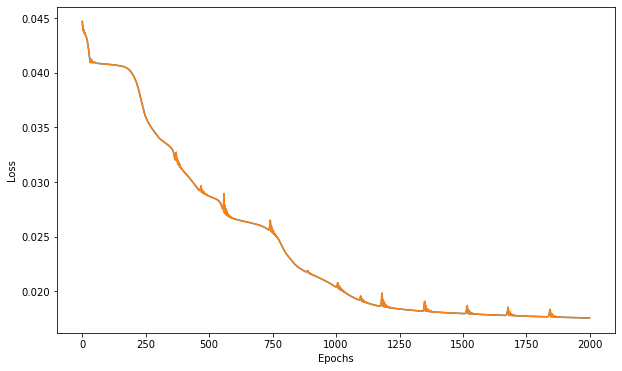

In [592]:
plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

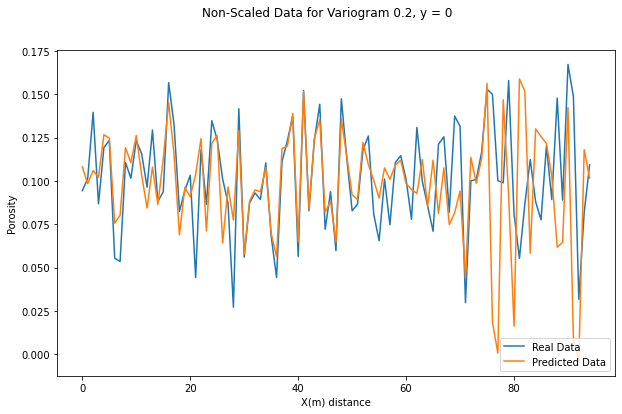

In [593]:
lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Non-Scaled Data for Variogram 0.2, y = 0')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.38064363602254675, pvalue=0.00014167334340065558)
STD: 0.03490893
MSE: 0.0012317582


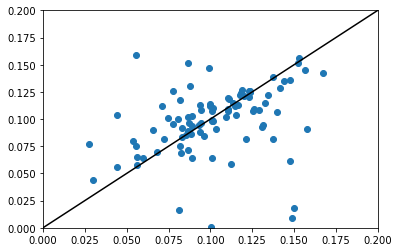

In [594]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.05216
Epoch: 100, loss: 0.04665
Epoch: 200, loss: 0.03423
Epoch: 300, loss: 0.02768
Epoch: 400, loss: 0.02576
Epoch: 500, loss: 0.02303
Epoch: 600, loss: 0.02125
Epoch: 700, loss: 0.02026
Epoch: 800, loss: 0.01989
Epoch: 900, loss: 0.01959
Epoch: 1000, loss: 0.01933
Epoch: 1100, loss: 0.01908
Epoch: 1200, loss: 0.01886
Epoch: 1300, loss: 0.01860
Epoch: 1400, loss: 0.01793
Epoch: 1500, loss: 0.01776
Epoch: 1600, loss: 0.01730
Epoch: 1700, loss: 0.01743
Epoch: 1800, loss: 0.01702
Epoch: 1900, loss: 0.01705


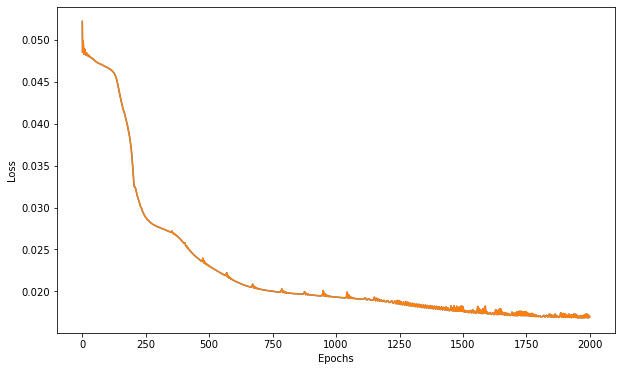

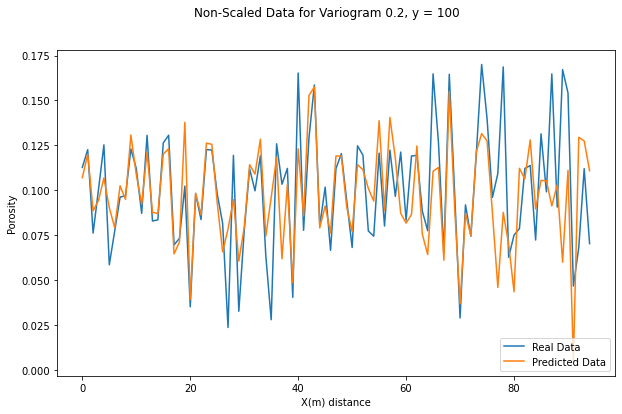

In [595]:
training_set = pd.read_csv('datasets/orig_v1_100.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Non-Scaled Data for Variogram 0.2, y = 100')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Epoch: 0, loss: 0.50429
Epoch: 100, loss: 0.01446
Epoch: 200, loss: 0.01443
Epoch: 300, loss: 0.01441
Epoch: 400, loss: 0.01439
Epoch: 500, loss: 0.01434
Epoch: 600, loss: 0.01412
Epoch: 700, loss: 0.01381
Epoch: 800, loss: 0.01367
Epoch: 900, loss: 0.01359
Epoch: 1000, loss: 0.01354
Epoch: 1100, loss: 0.01351
Epoch: 1200, loss: 0.01349
Epoch: 1300, loss: 0.01347
Epoch: 1400, loss: 0.01346
Epoch: 1500, loss: 0.01345
Epoch: 1600, loss: 0.01344
Epoch: 1700, loss: 0.01343
Epoch: 1800, loss: 0.01342
Epoch: 1900, loss: 0.01341


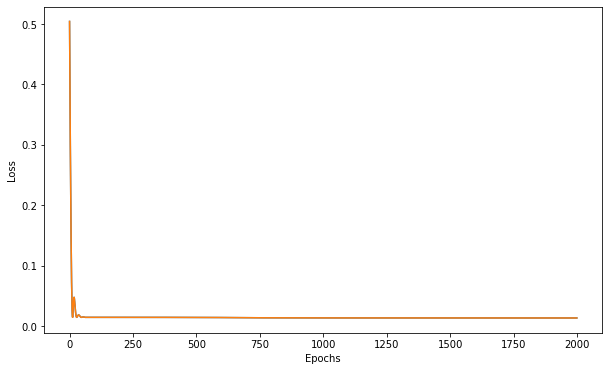

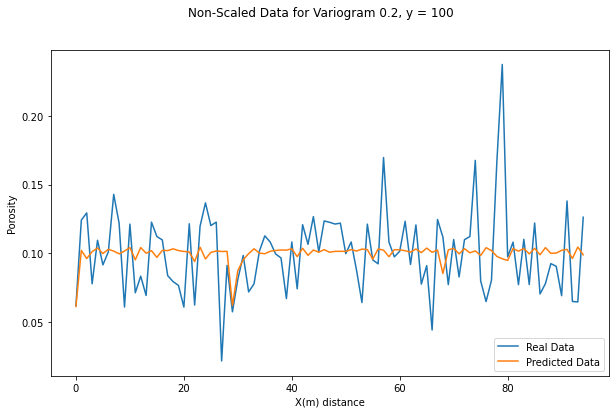

In [598]:
training_set = pd.read_csv('datasets/orig_v1_1000.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Non-Scaled Data for Variogram 0.2, y = 100')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.1603255997914066, pvalue=0.12065460519768859)
STD: 0.029643448
MSE: 0.00087878905


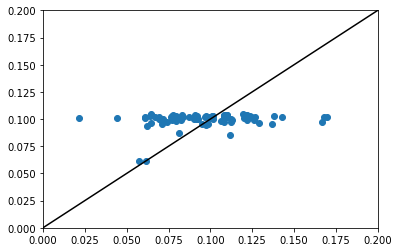

In [599]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.30453
Epoch: 100, loss: 0.04368
Epoch: 200, loss: 0.04363
Epoch: 300, loss: 0.04355
Epoch: 400, loss: 0.04339
Epoch: 500, loss: 0.04302
Epoch: 600, loss: 0.04230
Epoch: 700, loss: 0.04134
Epoch: 800, loss: 0.03534
Epoch: 900, loss: 0.03344
Epoch: 1000, loss: 0.03214
Epoch: 1100, loss: 0.03013
Epoch: 1200, loss: 0.02841
Epoch: 1300, loss: 0.02739
Epoch: 1400, loss: 0.02681
Epoch: 1500, loss: 0.02623
Epoch: 1600, loss: 0.02552
Epoch: 1700, loss: 0.02587
Epoch: 1800, loss: 0.02394
Epoch: 1900, loss: 0.02324


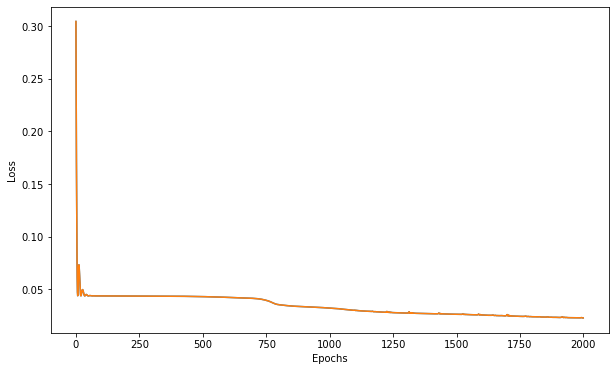

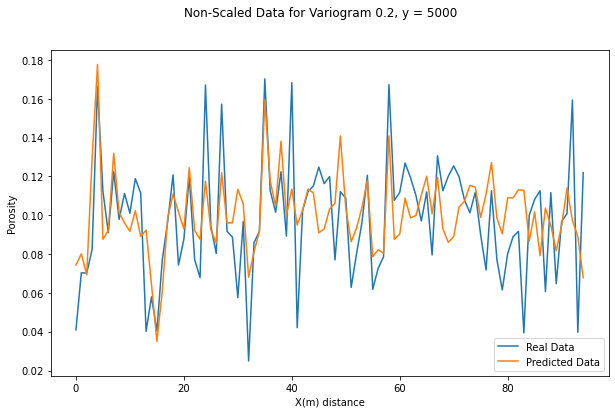

In [600]:
training_set = pd.read_csv('datasets/orig_v1_5000.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Non-Scaled Data for Variogram 0.2, y = 5000')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.5776674022638462, pvalue=8.847282468526702e-10)
STD: 0.024977658
MSE: 0.00063060265


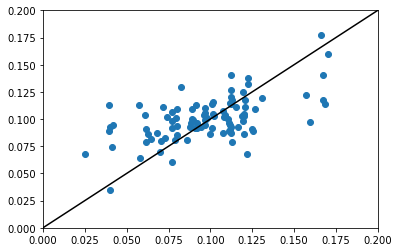

In [601]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.54862
Epoch: 100, loss: 0.02265
Epoch: 200, loss: 0.02258
Epoch: 300, loss: 0.02251
Epoch: 400, loss: 0.02238
Epoch: 500, loss: 0.02216
Epoch: 600, loss: 0.02208
Epoch: 700, loss: 0.02205
Epoch: 800, loss: 0.02203
Epoch: 900, loss: 0.02199
Epoch: 1000, loss: 0.02193
Epoch: 1100, loss: 0.02184
Epoch: 1200, loss: 0.02169
Epoch: 1300, loss: 0.02145
Epoch: 1400, loss: 0.02116
Epoch: 1500, loss: 0.02089
Epoch: 1600, loss: 0.02067
Epoch: 1700, loss: 0.02045
Epoch: 1800, loss: 0.01996
Epoch: 1900, loss: 0.01956


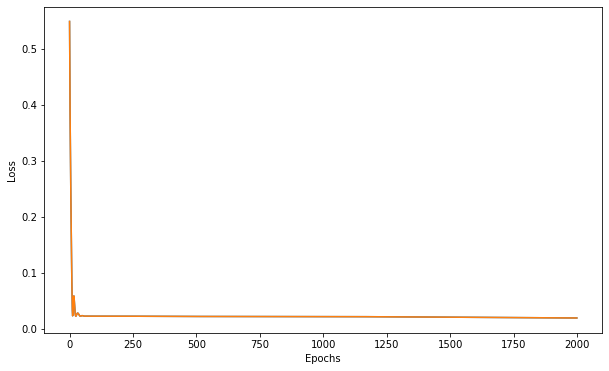

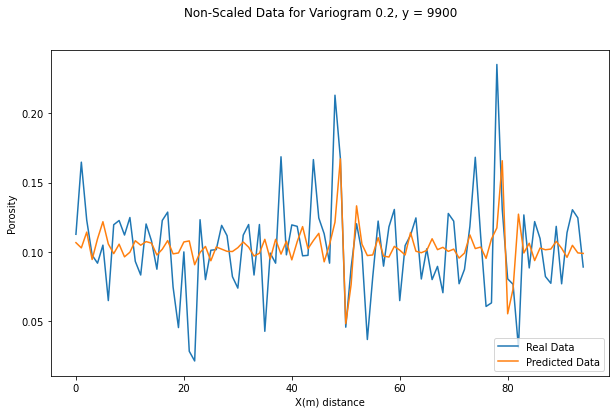

In [602]:
training_set = pd.read_csv('datasets/orig_v1_9900.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Non-Scaled Data for Variogram 0.2, y = 9900')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.32740883458597086, pvalue=0.0012007731333540331)
STD: 0.03268586
MSE: 0.0010684254


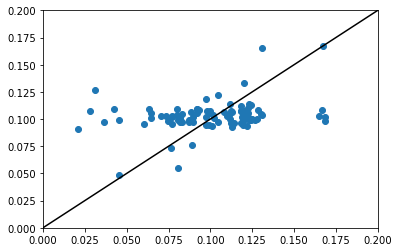

In [603]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 1.93703
Epoch: 100, loss: 0.02562
Epoch: 200, loss: 0.02225
Epoch: 300, loss: 0.01864
Epoch: 400, loss: 0.01583
Epoch: 500, loss: 0.01334
Epoch: 600, loss: 0.01092
Epoch: 700, loss: 0.00875
Epoch: 800, loss: 0.00697
Epoch: 900, loss: 0.00558


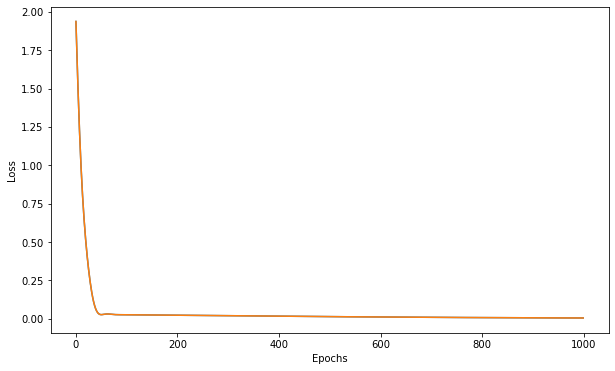

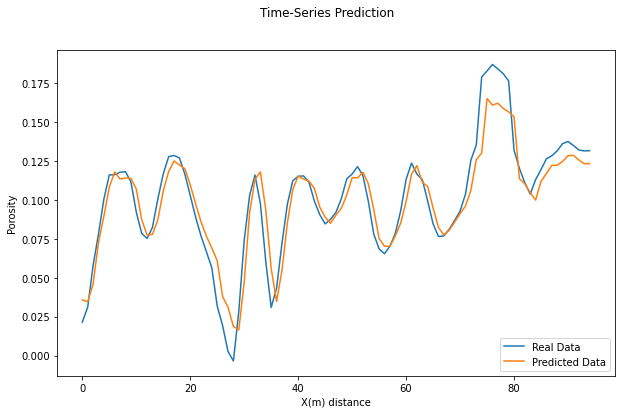

In [694]:
training_set = pd.read_csv('datasets/orig_sim2_0.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9478266855097148, pvalue=5.817386894942318e-48)
STD: 0.0128656
MSE: 0.00016849129


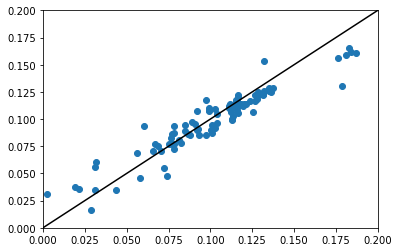

In [695]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.05564
Epoch: 100, loss: 0.00488
Epoch: 200, loss: 0.00242
Epoch: 300, loss: 0.00222
Epoch: 400, loss: 0.00219
Epoch: 500, loss: 0.00216
Epoch: 600, loss: 0.00211
Epoch: 700, loss: 0.00205
Epoch: 800, loss: 0.00200
Epoch: 900, loss: 0.00195
Epoch: 1000, loss: 0.00188
Epoch: 1100, loss: 0.00185
Epoch: 1200, loss: 0.00175
Epoch: 1300, loss: 0.00173
Epoch: 1400, loss: 0.00172
Epoch: 1500, loss: 0.00171
Epoch: 1600, loss: 0.00170
Epoch: 1700, loss: 0.00169
Epoch: 1800, loss: 0.00169
Epoch: 1900, loss: 0.00168


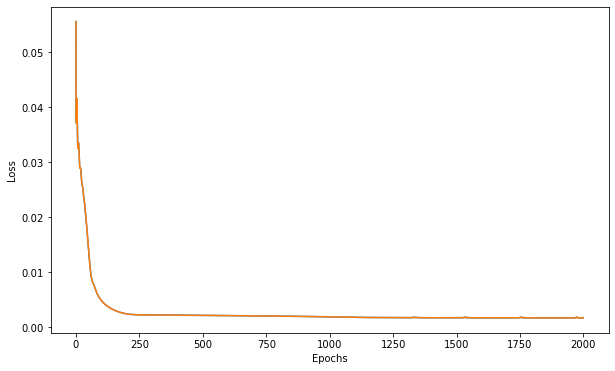

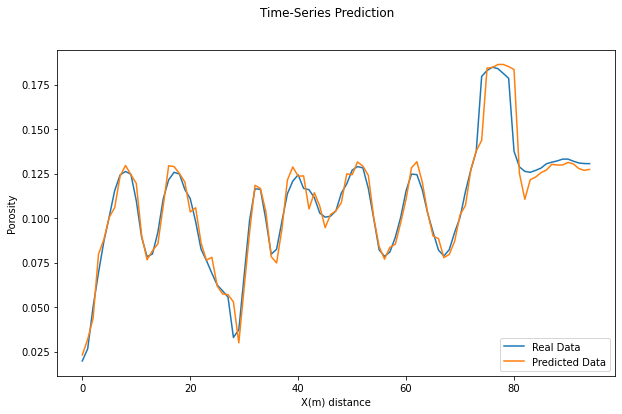

In [606]:
training_set = pd.read_csv('datasets/orig_sim2_100.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9697873102749882, pvalue=8.889382649247468e-59)
STD: 0.00795379
MSE: 6.329266e-05


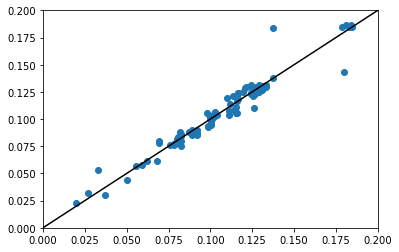

In [607]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.13287
Epoch: 100, loss: 0.00233
Epoch: 200, loss: 0.00223
Epoch: 300, loss: 0.00213
Epoch: 400, loss: 0.00202
Epoch: 500, loss: 0.00194
Epoch: 600, loss: 0.00188
Epoch: 700, loss: 0.00181
Epoch: 800, loss: 0.00174
Epoch: 900, loss: 0.00168
Epoch: 1000, loss: 0.00162
Epoch: 1100, loss: 0.00174
Epoch: 1200, loss: 0.00162
Epoch: 1300, loss: 0.00150
Epoch: 1400, loss: 0.00148
Epoch: 1500, loss: 0.00148
Epoch: 1600, loss: 0.00147
Epoch: 1700, loss: 0.00149
Epoch: 1800, loss: 0.00153
Epoch: 1900, loss: 0.00151


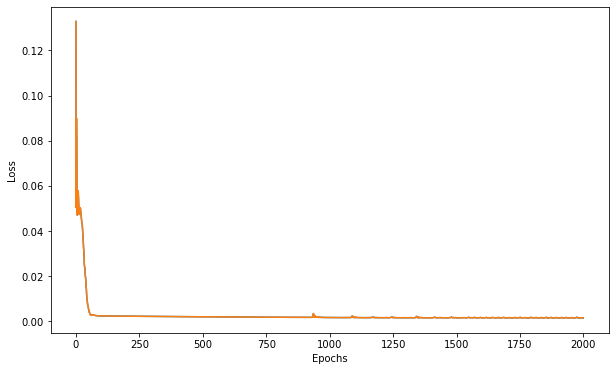

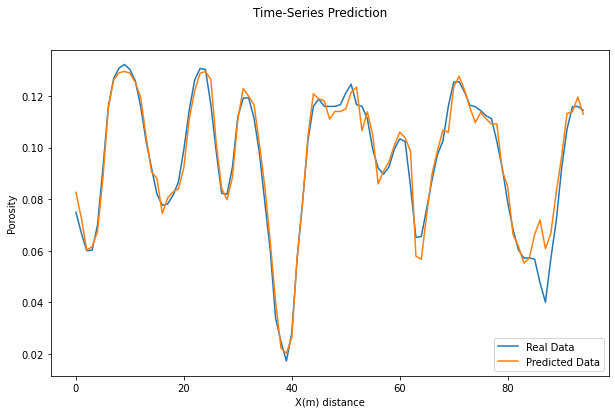

In [608]:
training_set = pd.read_csv('datasets/orig_sim2_5000.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
num_epochs = 2000
learning_rate = 0.1

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9796131711333959, pvalue=1.2619148309419319e-66)
STD: 0.0054505602
MSE: 3.0891613e-05


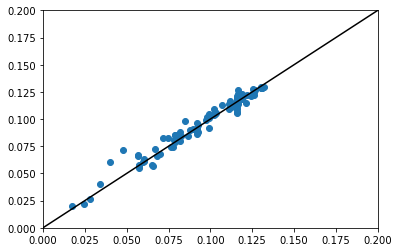

In [609]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.91360
Epoch: 100, loss: 0.01431
Epoch: 200, loss: 0.00690
Epoch: 300, loss: 0.00308
Epoch: 400, loss: 0.00221
Epoch: 500, loss: 0.00176
Epoch: 600, loss: 0.00153
Epoch: 700, loss: 0.00141
Epoch: 800, loss: 0.00135
Epoch: 900, loss: 0.00132
Epoch: 1000, loss: 0.00131
Epoch: 1100, loss: 0.00130
Epoch: 1200, loss: 0.00129
Epoch: 1300, loss: 0.00129
Epoch: 1400, loss: 0.00129
Epoch: 1500, loss: 0.00128
Epoch: 1600, loss: 0.00128
Epoch: 1700, loss: 0.00128
Epoch: 1800, loss: 0.00128
Epoch: 1900, loss: 0.00128


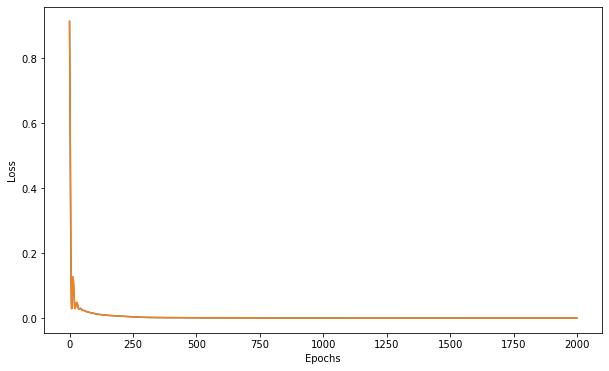

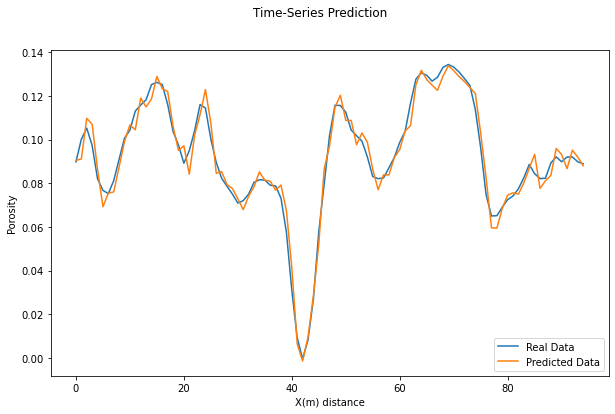

In [610]:
training_set = pd.read_csv('datasets/orig_sim2_9900.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.984142423073092, pvalue=1.1788931838551145e-71)
STD: 0.0047068135
MSE: 2.2155193e-05


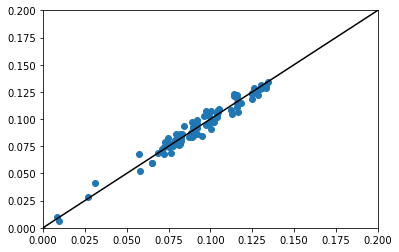

In [611]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.71417
Epoch: 100, loss: 0.01516
Epoch: 200, loss: 0.01138
Epoch: 300, loss: 0.00359
Epoch: 400, loss: 0.00142
Epoch: 500, loss: 0.00111
Epoch: 600, loss: 0.00109
Epoch: 700, loss: 0.00107
Epoch: 800, loss: 0.00104
Epoch: 900, loss: 0.00098
Epoch: 1000, loss: 0.00081
Epoch: 1100, loss: 0.00069
Epoch: 1200, loss: 0.00066
Epoch: 1300, loss: 0.00064
Epoch: 1400, loss: 0.00064
Epoch: 1500, loss: 0.00063
Epoch: 1600, loss: 0.00062
Epoch: 1700, loss: 0.00062
Epoch: 1800, loss: 0.00061
Epoch: 1900, loss: 0.00060


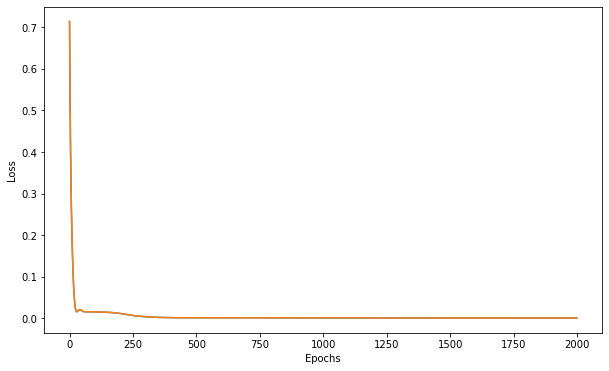

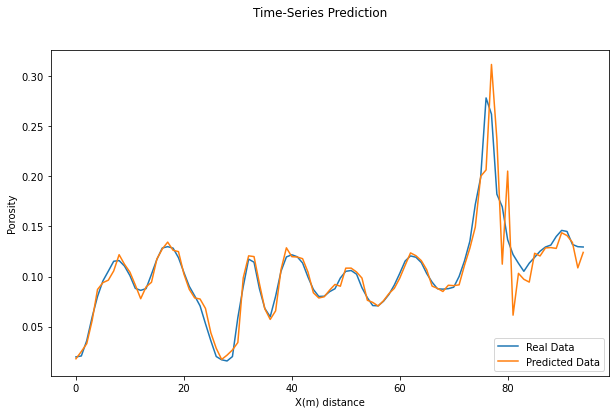

In [612]:
training_set = pd.read_csv('datasets/orig_sim3_0.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9247900696111376, pvalue=8.324159219942848e-41)
STD: 0.016670031
MSE: 0.00027901522


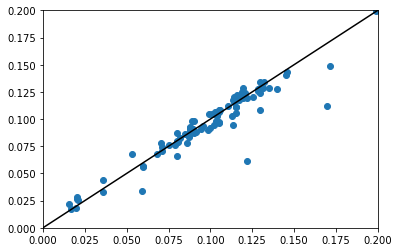

In [613]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.89587
Epoch: 100, loss: 0.01051
Epoch: 200, loss: 0.00579
Epoch: 300, loss: 0.00399
Epoch: 400, loss: 0.00199
Epoch: 500, loss: 0.00167
Epoch: 600, loss: 0.00140
Epoch: 700, loss: 0.00082
Epoch: 800, loss: 0.00072
Epoch: 900, loss: 0.00070
Epoch: 1000, loss: 0.00069
Epoch: 1100, loss: 0.00069
Epoch: 1200, loss: 0.00069
Epoch: 1300, loss: 0.00068
Epoch: 1400, loss: 0.00068
Epoch: 1500, loss: 0.00068
Epoch: 1600, loss: 0.00068
Epoch: 1700, loss: 0.00068
Epoch: 1800, loss: 0.00068
Epoch: 1900, loss: 0.00067


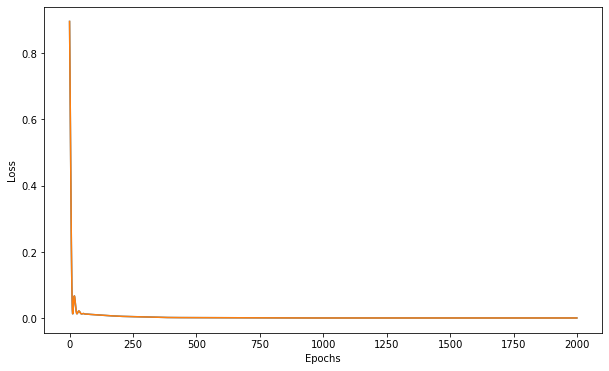

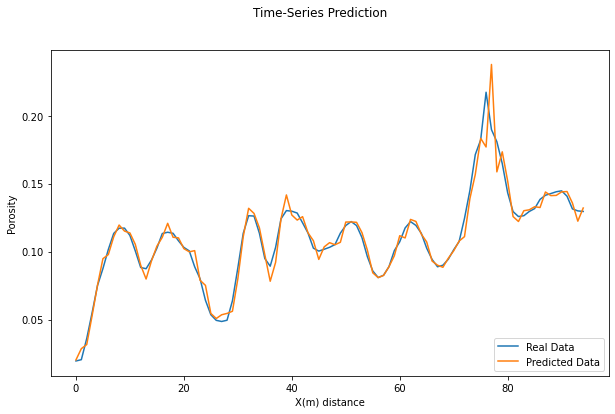

In [614]:
training_set = pd.read_csv('datasets/orig_sim3_100.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9672122476066619, pvalue=3.761560128409477e-57)
STD: 0.008434069
MSE: 7.1135386e-05


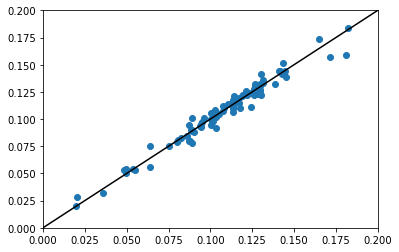

In [615]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.05189
Epoch: 100, loss: 0.00156
Epoch: 200, loss: 0.00146
Epoch: 300, loss: 0.00144
Epoch: 400, loss: 0.00143
Epoch: 500, loss: 0.00143
Epoch: 600, loss: 0.00143
Epoch: 700, loss: 0.00142
Epoch: 800, loss: 0.00142
Epoch: 900, loss: 0.00142
Epoch: 1000, loss: 0.00141
Epoch: 1100, loss: 0.00141
Epoch: 1200, loss: 0.00140
Epoch: 1300, loss: 0.00139
Epoch: 1400, loss: 0.00138
Epoch: 1500, loss: 0.00137
Epoch: 1600, loss: 0.00137
Epoch: 1700, loss: 0.00136
Epoch: 1800, loss: 0.00138
Epoch: 1900, loss: 0.00135


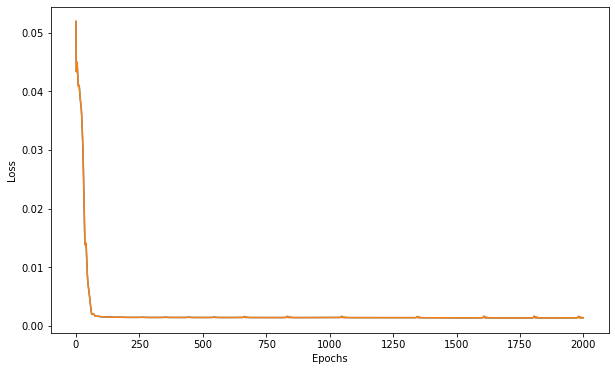

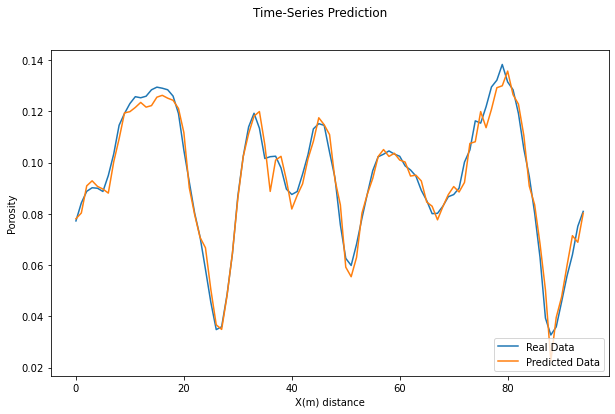

In [616]:
training_set = pd.read_csv('datasets/orig_sim3_1000.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9849261439023731, pvalue=1.1364018538584063e-72)
STD: 0.004398221
MSE: 1.9561174e-05


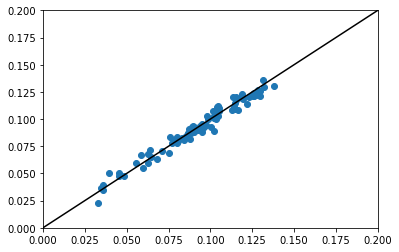

In [617]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.28635
Epoch: 100, loss: 0.01190
Epoch: 200, loss: 0.00416
Epoch: 300, loss: 0.00322
Epoch: 400, loss: 0.00261
Epoch: 500, loss: 0.00195
Epoch: 600, loss: 0.00185
Epoch: 700, loss: 0.00179
Epoch: 800, loss: 0.00174
Epoch: 900, loss: 0.00170
Epoch: 1000, loss: 0.00167
Epoch: 1100, loss: 0.00164
Epoch: 1200, loss: 0.00161
Epoch: 1300, loss: 0.00158
Epoch: 1400, loss: 0.00156
Epoch: 1500, loss: 0.00154
Epoch: 1600, loss: 0.00153
Epoch: 1700, loss: 0.00152
Epoch: 1800, loss: 0.00151
Epoch: 1900, loss: 0.00150


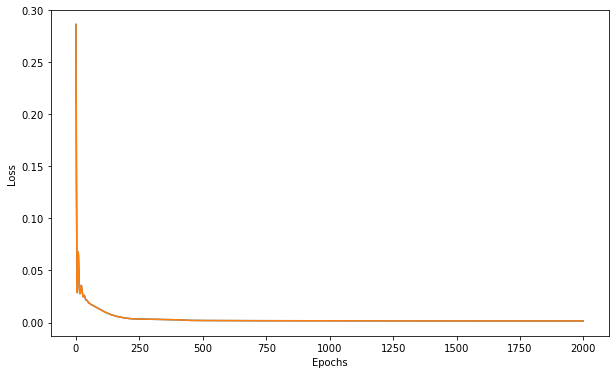

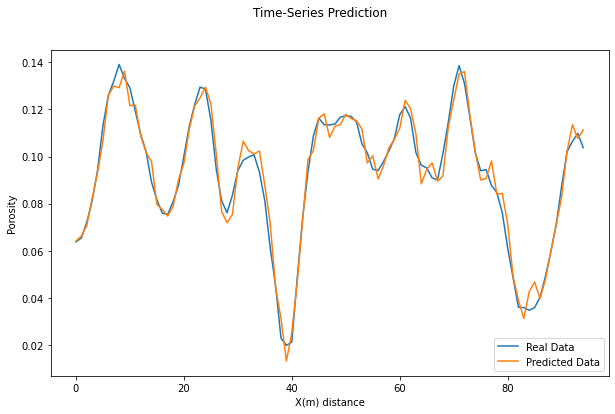

In [618]:
training_set = pd.read_csv('datasets/orig_sim3_5000.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9850268826808417, pvalue=8.338712028659127e-73)
STD: 0.0048471256
MSE: 2.3759054e-05


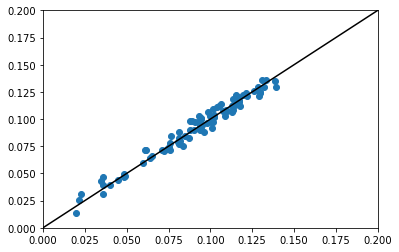

In [619]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.88479
Epoch: 100, loss: 0.02221
Epoch: 200, loss: 0.00546
Epoch: 300, loss: 0.00265
Epoch: 400, loss: 0.00186
Epoch: 500, loss: 0.00158
Epoch: 600, loss: 0.00152
Epoch: 700, loss: 0.00148
Epoch: 800, loss: 0.00144
Epoch: 900, loss: 0.00143
Epoch: 1000, loss: 0.00142
Epoch: 1100, loss: 0.00142
Epoch: 1200, loss: 0.00141
Epoch: 1300, loss: 0.00141
Epoch: 1400, loss: 0.00141
Epoch: 1500, loss: 0.00141
Epoch: 1600, loss: 0.00141
Epoch: 1700, loss: 0.00141
Epoch: 1800, loss: 0.00141
Epoch: 1900, loss: 0.00140


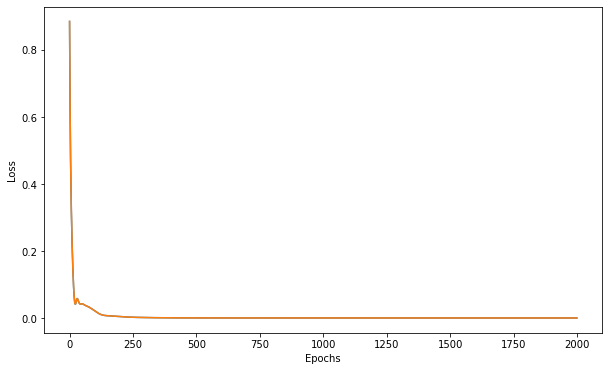

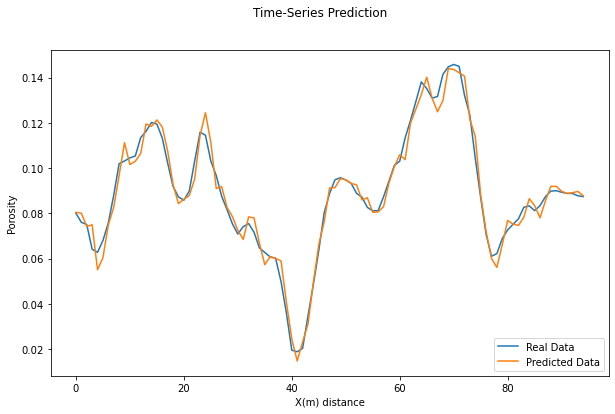

In [620]:
training_set = pd.read_csv('datasets/orig_sim3_9900.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9861481900199461, pvalue=2.2911568930708585e-74)
STD: 0.0044368347
MSE: 1.9689773e-05


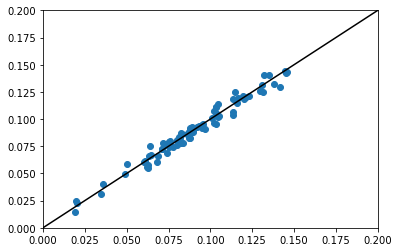

In [621]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.48324
Epoch: 100, loss: 0.00978
Epoch: 200, loss: 0.00225
Epoch: 300, loss: 0.00127
Epoch: 400, loss: 0.00100
Epoch: 500, loss: 0.00085
Epoch: 600, loss: 0.00075
Epoch: 700, loss: 0.00071
Epoch: 800, loss: 0.00070
Epoch: 900, loss: 0.00070
Epoch: 1000, loss: 0.00069
Epoch: 1100, loss: 0.00069
Epoch: 1200, loss: 0.00068
Epoch: 1300, loss: 0.00068
Epoch: 1400, loss: 0.00068
Epoch: 1500, loss: 0.00067
Epoch: 1600, loss: 0.00067
Epoch: 1700, loss: 0.00066
Epoch: 1800, loss: 0.00066
Epoch: 1900, loss: 0.00066


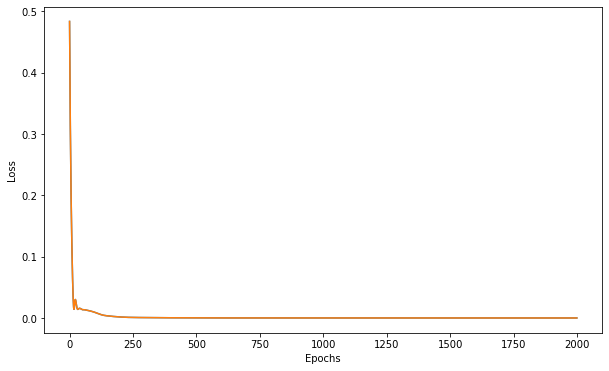

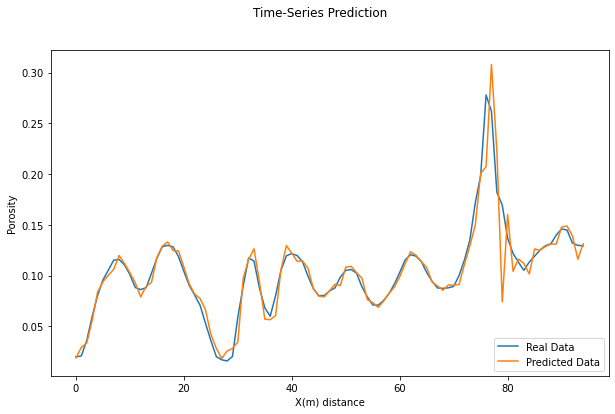

In [622]:
training_set = pd.read_csv('datasets/orig_sim4_0.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9331051525933646, pvalue=4.340731755617965e-43)
STD: 0.015448042
MSE: 0.0002393003


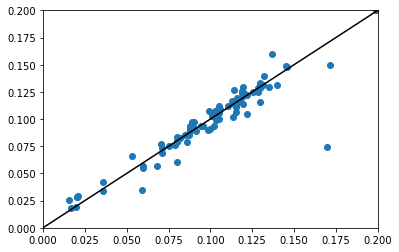

In [623]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.64909
Epoch: 100, loss: 0.01454
Epoch: 200, loss: 0.00551
Epoch: 300, loss: 0.00235
Epoch: 400, loss: 0.00125
Epoch: 500, loss: 0.00096
Epoch: 600, loss: 0.00083
Epoch: 700, loss: 0.00081
Epoch: 800, loss: 0.00079
Epoch: 900, loss: 0.00077
Epoch: 1000, loss: 0.00076
Epoch: 1100, loss: 0.00074
Epoch: 1200, loss: 0.00073
Epoch: 1300, loss: 0.00072
Epoch: 1400, loss: 0.00072
Epoch: 1500, loss: 0.00071
Epoch: 1600, loss: 0.00071
Epoch: 1700, loss: 0.00071
Epoch: 1800, loss: 0.00071
Epoch: 1900, loss: 0.00071


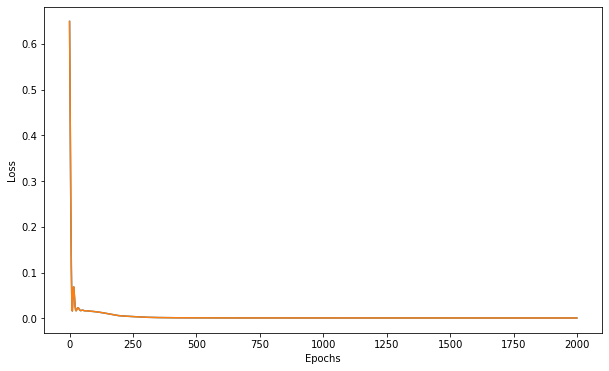

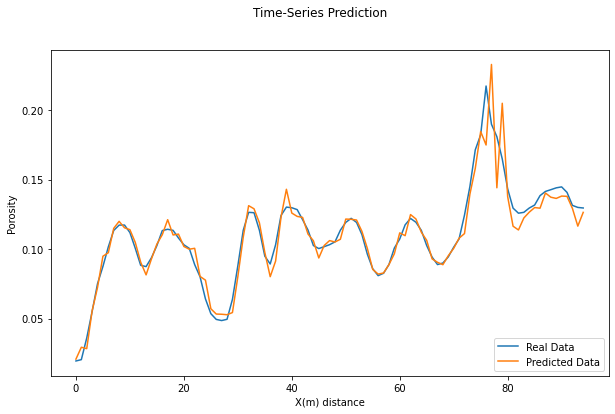

In [624]:
training_set = pd.read_csv('datasets/orig_sim4_100.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9538253526521799, pvalue=2.2780531827275524e-50)
STD: 0.009961927
MSE: 0.000100084166


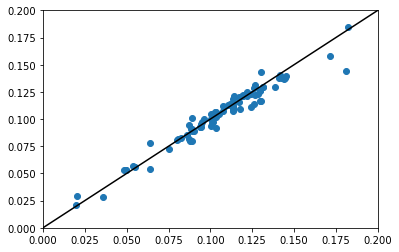

In [625]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.50663
Epoch: 100, loss: 0.01889
Epoch: 200, loss: 0.00773
Epoch: 300, loss: 0.00502
Epoch: 400, loss: 0.00381
Epoch: 500, loss: 0.00305
Epoch: 600, loss: 0.00276
Epoch: 700, loss: 0.00263
Epoch: 800, loss: 0.00256
Epoch: 900, loss: 0.00248
Epoch: 1000, loss: 0.00239
Epoch: 1100, loss: 0.00226
Epoch: 1200, loss: 0.00216
Epoch: 1300, loss: 0.00212
Epoch: 1400, loss: 0.00208
Epoch: 1500, loss: 0.00205
Epoch: 1600, loss: 0.00202
Epoch: 1700, loss: 0.00201
Epoch: 1800, loss: 0.00199
Epoch: 1900, loss: 0.00198


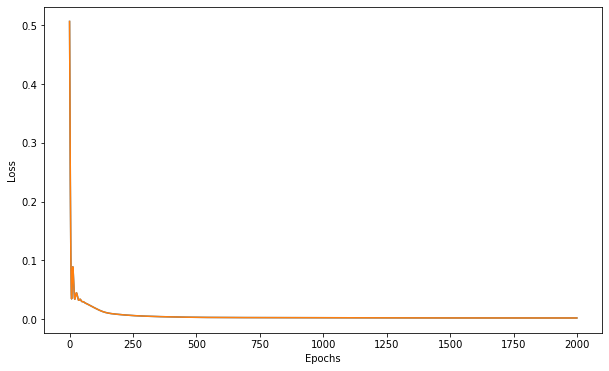

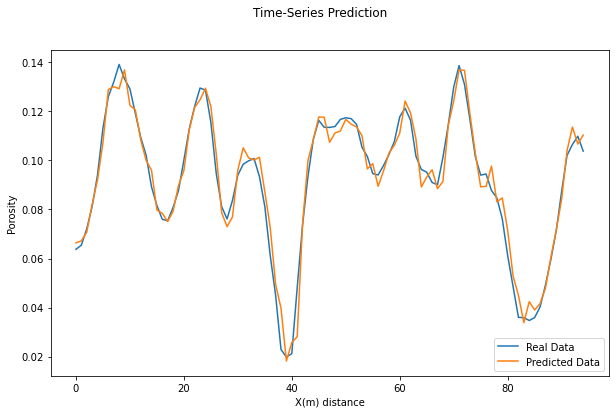

In [626]:
training_set = pd.read_csv('datasets/orig_sim4_5000.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9820282156435616, pvalue=3.78735885755973e-69)
STD: 0.0053154756
MSE: 2.858703e-05


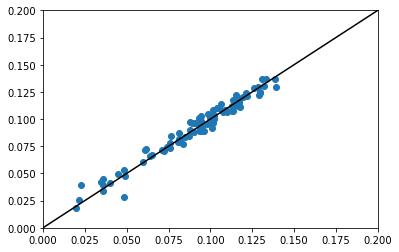

In [627]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.09677
Epoch: 100, loss: 0.00298
Epoch: 200, loss: 0.00172
Epoch: 300, loss: 0.00160
Epoch: 400, loss: 0.00157
Epoch: 500, loss: 0.00155
Epoch: 600, loss: 0.00153
Epoch: 700, loss: 0.00151
Epoch: 800, loss: 0.00149
Epoch: 900, loss: 0.00148
Epoch: 1000, loss: 0.00147
Epoch: 1100, loss: 0.00147
Epoch: 1200, loss: 0.00146
Epoch: 1300, loss: 0.00146
Epoch: 1400, loss: 0.00146
Epoch: 1500, loss: 0.00145
Epoch: 1600, loss: 0.00146
Epoch: 1700, loss: 0.00144
Epoch: 1800, loss: 0.00143
Epoch: 1900, loss: 0.00143


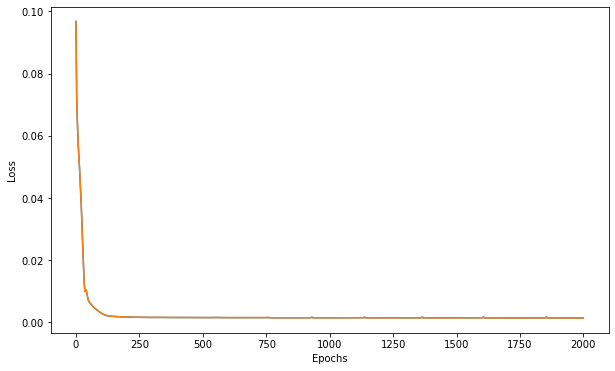

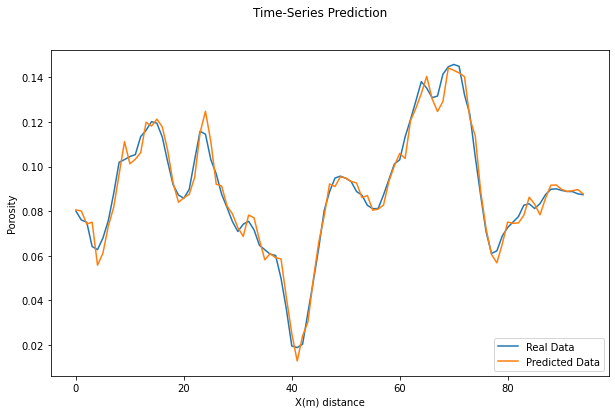

In [628]:
training_set = pd.read_csv('datasets/orig_sim4_9900.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9861729300804498, pvalue=2.1095736256450835e-74)
STD: 0.004432789
MSE: 1.9657637e-05


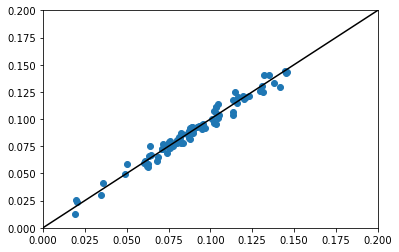

In [629]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

## Scaling 50

In [727]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, p):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.p = p
        #self.relu = nn.Sigmoid()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_layers)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        #out = nn.functional.dropout(out, p=self.p, training=True)
        #out = self.relu(out) #relu
        
        return out

Epoch: 0, loss: 0.04559
Epoch: 100, loss: 0.04295
Epoch: 200, loss: 0.04039
Epoch: 300, loss: 0.01951
Epoch: 400, loss: 0.01184
Epoch: 500, loss: 0.01048
Epoch: 600, loss: 0.00951
Epoch: 700, loss: 0.00849
Epoch: 800, loss: 0.00794
Epoch: 900, loss: 0.00747
Epoch: 1000, loss: 0.00864
Epoch: 1100, loss: 0.00668
Epoch: 1200, loss: 0.00630
Epoch: 1300, loss: 0.00685
Epoch: 1400, loss: 0.00610
Epoch: 1500, loss: 0.00570
Epoch: 1600, loss: 0.00564
Epoch: 1700, loss: 0.00498
Epoch: 1800, loss: 0.00545
Epoch: 1900, loss: 0.00526


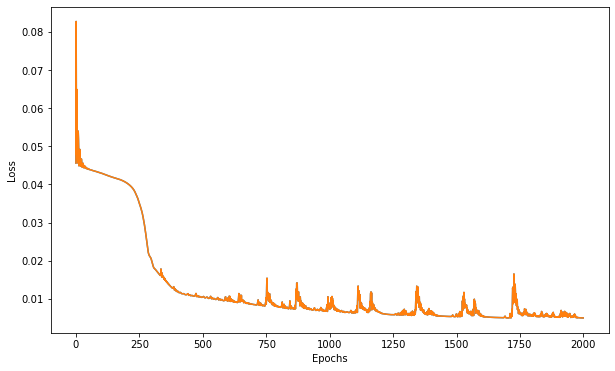

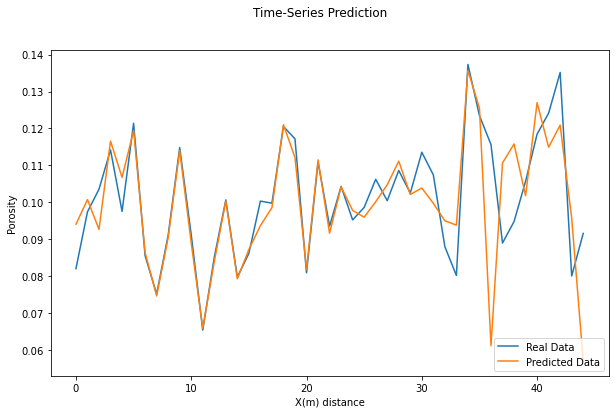

In [631]:
training_set = pd.read_csv('datasets/scaled_v1_50_100.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.06

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.25

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.7259416338594852, pvalue=1.6717884230431982e-08)
STD: 0.012090075
MSE: 0.00014732283


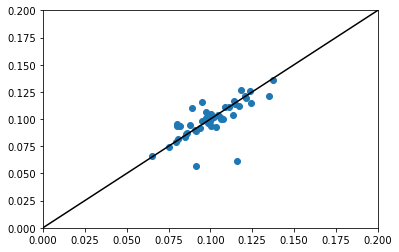

In [632]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.03434
Epoch: 100, loss: 0.02863
Epoch: 200, loss: 0.02862
Epoch: 300, loss: 0.02779
Epoch: 400, loss: 0.02224
Epoch: 500, loss: 0.00750
Epoch: 600, loss: 0.00563
Epoch: 700, loss: 0.00439
Epoch: 800, loss: 0.00388
Epoch: 900, loss: 0.00362
Epoch: 1000, loss: 0.00350
Epoch: 1100, loss: 0.00331
Epoch: 1200, loss: 0.00313
Epoch: 1300, loss: 0.00305
Epoch: 1400, loss: 0.00294
Epoch: 1500, loss: 0.00291
Epoch: 1600, loss: 0.00271
Epoch: 1700, loss: 0.00256
Epoch: 1800, loss: 0.00249
Epoch: 1900, loss: 0.00240


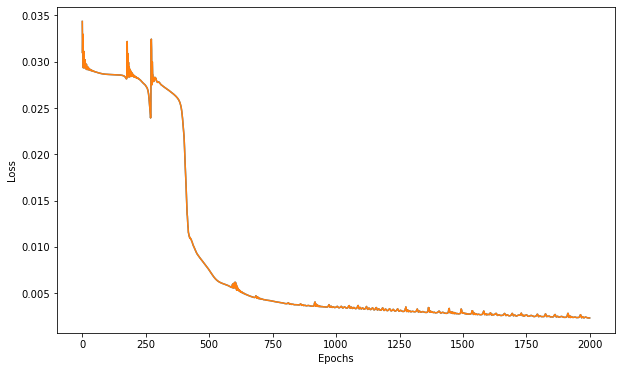

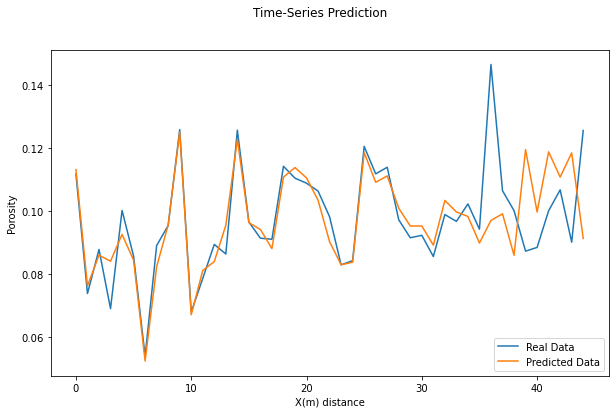

In [635]:
training_set = pd.read_csv('datasets/scaled_v1_50_115.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.06

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.25

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.7022940779396366, pvalue=7.592919485466612e-08)
STD: 0.01241304
MSE: 0.0001541719


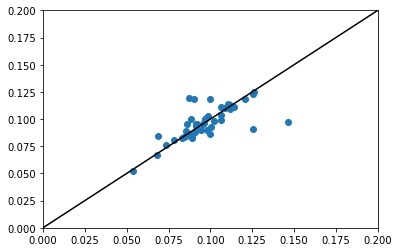

In [636]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.09585
Epoch: 100, loss: 0.05391
Epoch: 200, loss: 0.01500
Epoch: 300, loss: 0.01024
Epoch: 400, loss: 0.01095
Epoch: 500, loss: 0.00598
Epoch: 600, loss: 0.00468
Epoch: 700, loss: 0.00429
Epoch: 800, loss: 0.00415
Epoch: 900, loss: 0.00377
Epoch: 1000, loss: 0.00359
Epoch: 1100, loss: 0.00383
Epoch: 1200, loss: 0.00364
Epoch: 1300, loss: 0.00354
Epoch: 1400, loss: 0.00352
Epoch: 1500, loss: 0.00314
Epoch: 1600, loss: 0.00303
Epoch: 1700, loss: 0.00285
Epoch: 1800, loss: 0.00272
Epoch: 1900, loss: 0.00268


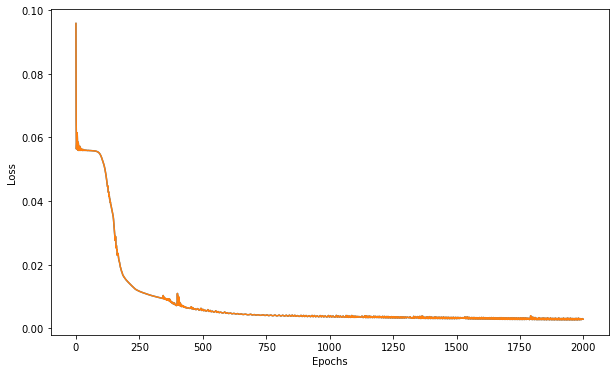

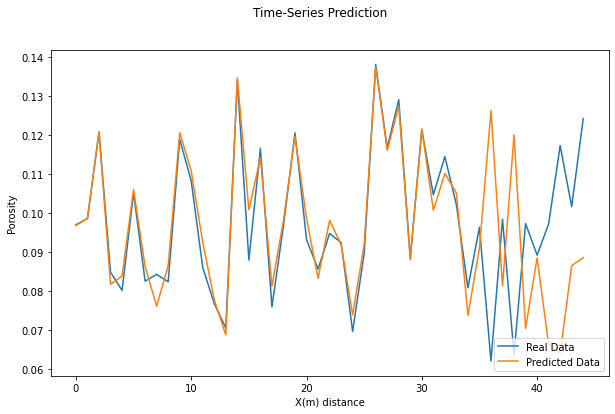

In [638]:
training_set = pd.read_csv('datasets/scaled_v1_50_515.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.06

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.25

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.5477942316846119, pvalue=9.826265082629904e-05)
STD: 0.017740104
MSE: 0.00031549035


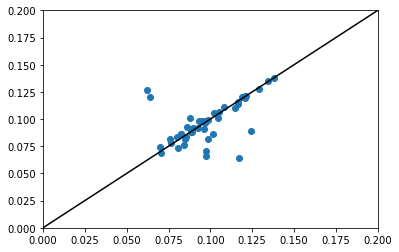

In [639]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.04679
Epoch: 100, loss: 0.03217
Epoch: 200, loss: 0.03188
Epoch: 300, loss: 0.03183
Epoch: 400, loss: 0.03179
Epoch: 500, loss: 0.02973
Epoch: 600, loss: 0.02513
Epoch: 700, loss: 0.01765
Epoch: 800, loss: 0.01250
Epoch: 900, loss: 0.01149
Epoch: 1000, loss: 0.01032
Epoch: 1100, loss: 0.00968
Epoch: 1200, loss: 0.00879
Epoch: 1300, loss: 0.00757
Epoch: 1400, loss: 0.00518
Epoch: 1500, loss: 0.00776
Epoch: 1600, loss: 0.00407
Epoch: 1700, loss: 0.00389
Epoch: 1800, loss: 0.00326
Epoch: 1900, loss: 0.00296


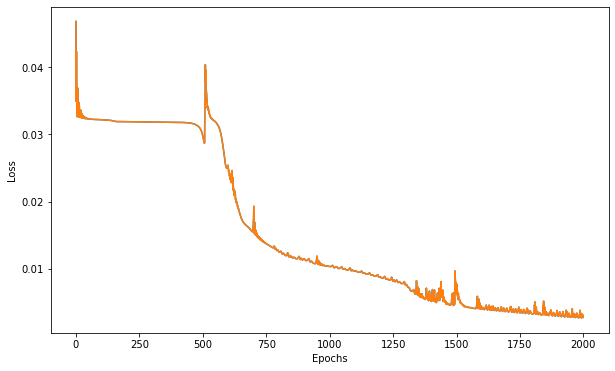

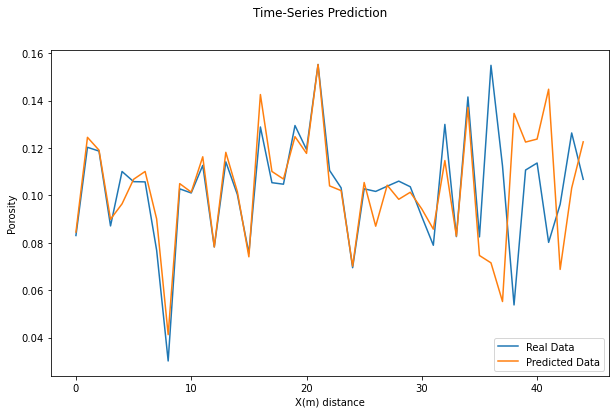

In [640]:
training_set = pd.read_csv('datasets/scaled_v1_50_999.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.06

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.25

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.5112851388938686, pvalue=0.00033160187998933086)
STD: 0.023183787
MSE: 0.0005375003


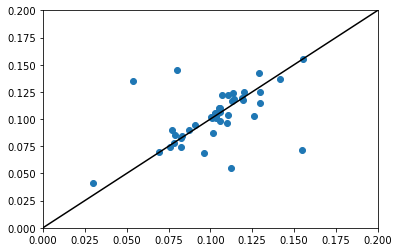

In [641]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.08787
Epoch: 100, loss: 0.00759
Epoch: 200, loss: 0.00580
Epoch: 300, loss: 0.00514
Epoch: 400, loss: 0.00486
Epoch: 500, loss: 0.00464
Epoch: 600, loss: 0.00482
Epoch: 700, loss: 0.00432
Epoch: 800, loss: 0.00417
Epoch: 900, loss: 0.00341
Epoch: 1000, loss: 0.00758
Epoch: 1100, loss: 0.00508
Epoch: 1200, loss: 0.00467
Epoch: 1300, loss: 0.00430
Epoch: 1400, loss: 0.00391
Epoch: 1500, loss: 0.00358
Epoch: 1600, loss: 0.00330
Epoch: 1700, loss: 0.00320
Epoch: 1800, loss: 0.00313
Epoch: 1900, loss: 0.00312


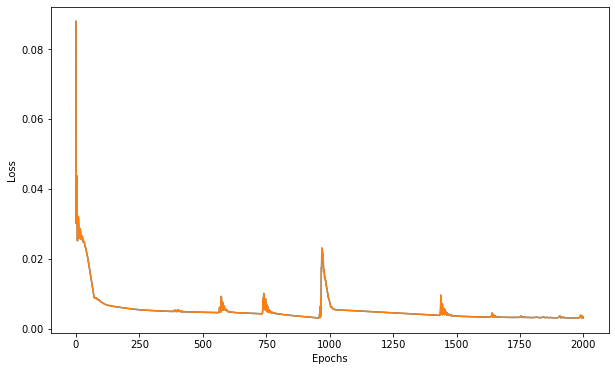

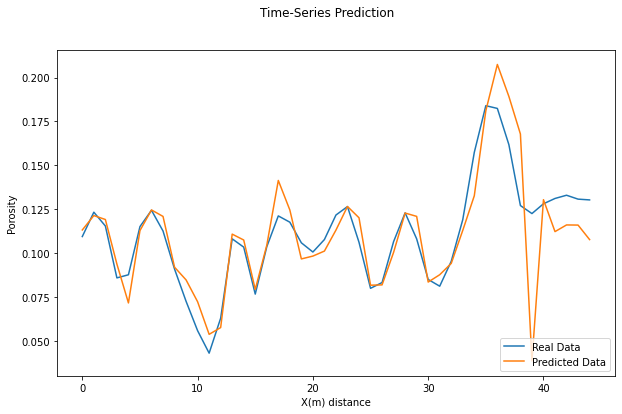

In [728]:
training_set = pd.read_csv('datasets/scaled_v2_50_100.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.06

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.25

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.8369301870226021, pvalue=7.942875284297126e-13)
STD: 0.017755501
MSE: 0.0003154731


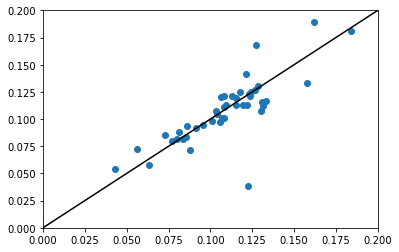

In [729]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.51400
Epoch: 100, loss: 0.02317
Epoch: 200, loss: 0.00845
Epoch: 300, loss: 0.00593
Epoch: 400, loss: 0.00565
Epoch: 500, loss: 0.00533
Epoch: 600, loss: 0.00520
Epoch: 700, loss: 0.00503
Epoch: 800, loss: 0.00489
Epoch: 900, loss: 0.00472
Epoch: 1000, loss: 0.00453
Epoch: 1100, loss: 0.00438
Epoch: 1200, loss: 0.00421
Epoch: 1300, loss: 0.00400
Epoch: 1400, loss: 0.00380
Epoch: 1500, loss: 0.00362
Epoch: 1600, loss: 0.00349
Epoch: 1700, loss: 0.00325
Epoch: 1800, loss: 0.00318
Epoch: 1900, loss: 0.00327


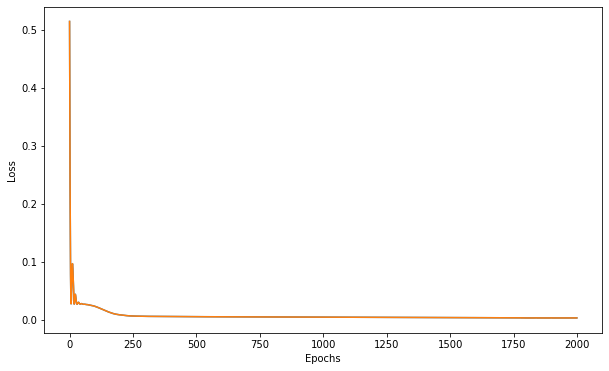

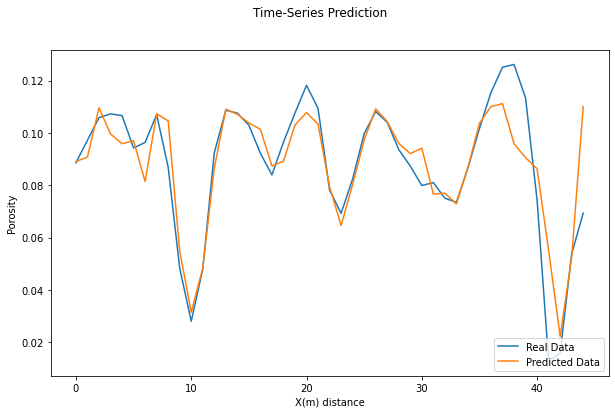

In [644]:
training_set = pd.read_csv('datasets/scaled_v2_50_115.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.06

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.25

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.8832237638886373, pvalue=9.82746548512678e-16)
STD: 0.012245355
MSE: 0.00015008253


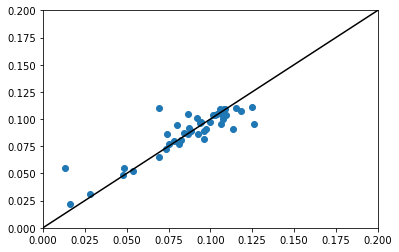

In [645]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 1.05048
Epoch: 100, loss: 0.03436
Epoch: 200, loss: 0.01815
Epoch: 300, loss: 0.01241
Epoch: 400, loss: 0.01003
Epoch: 500, loss: 0.00923
Epoch: 600, loss: 0.00882
Epoch: 700, loss: 0.00853
Epoch: 800, loss: 0.00820
Epoch: 900, loss: 0.00785
Epoch: 1000, loss: 0.00757
Epoch: 1100, loss: 0.00741
Epoch: 1200, loss: 0.00728
Epoch: 1300, loss: 0.00717
Epoch: 1400, loss: 0.00705
Epoch: 1500, loss: 0.00688
Epoch: 1600, loss: 0.00662
Epoch: 1700, loss: 0.00626
Epoch: 1800, loss: 0.00574
Epoch: 1900, loss: 0.00528


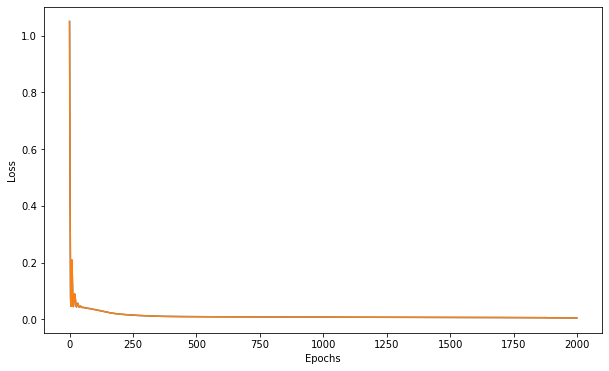

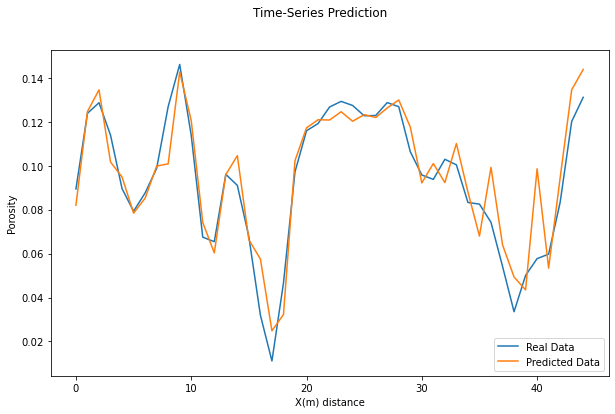

In [646]:
training_set = pd.read_csv('datasets/scaled_v2_50_515.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.06

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.25

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9283603015284881, pvalue=4.2734828140893e-20)
STD: 0.011564803
MSE: 0.00014056679


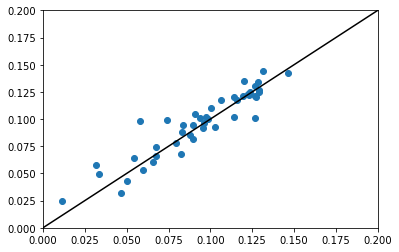

In [647]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.14971
Epoch: 100, loss: 0.00867
Epoch: 200, loss: 0.00641
Epoch: 300, loss: 0.00608
Epoch: 400, loss: 0.00578
Epoch: 500, loss: 0.00563
Epoch: 600, loss: 0.00552
Epoch: 700, loss: 0.00527
Epoch: 800, loss: 0.00518
Epoch: 900, loss: 0.00538
Epoch: 1000, loss: 0.00501
Epoch: 1100, loss: 0.00489
Epoch: 1200, loss: 0.00471
Epoch: 1300, loss: 0.00460
Epoch: 1400, loss: 0.00448
Epoch: 1500, loss: 0.00444
Epoch: 1600, loss: 0.00438
Epoch: 1700, loss: 0.00435
Epoch: 1800, loss: 0.00450
Epoch: 1900, loss: 0.00449


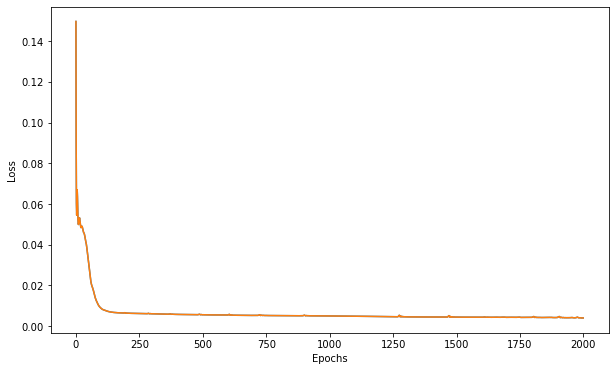

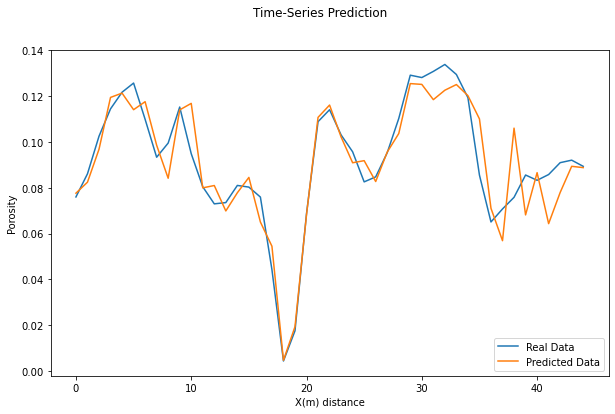

In [648]:
training_set = pd.read_csv('datasets/scaled_v2_50_999.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.06

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.25

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9296780882976986, pvalue=2.9054913365140524e-20)
STD: 0.009996438
MSE: 0.00010037726


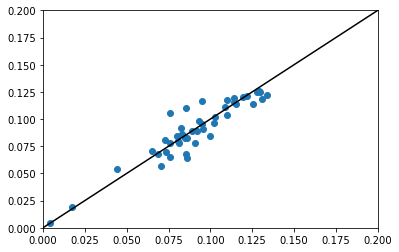

In [649]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.08466
Epoch: 100, loss: 0.00579
Epoch: 200, loss: 0.00349
Epoch: 300, loss: 0.00308
Epoch: 400, loss: 0.00247
Epoch: 500, loss: 0.00162
Epoch: 600, loss: 0.00152
Epoch: 700, loss: 0.00147
Epoch: 800, loss: 0.00145
Epoch: 900, loss: 0.00142
Epoch: 1000, loss: 0.00149
Epoch: 1100, loss: 0.00138
Epoch: 1200, loss: 0.00135
Epoch: 1300, loss: 0.00135
Epoch: 1400, loss: 0.00157
Epoch: 1500, loss: 0.00138
Epoch: 1600, loss: 0.00132
Epoch: 1700, loss: 0.00135
Epoch: 1800, loss: 0.00174
Epoch: 1900, loss: 0.00138


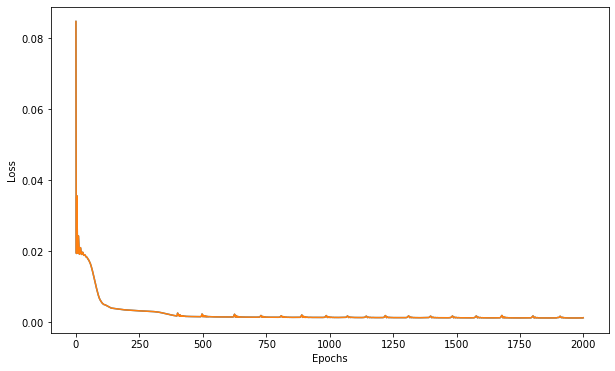

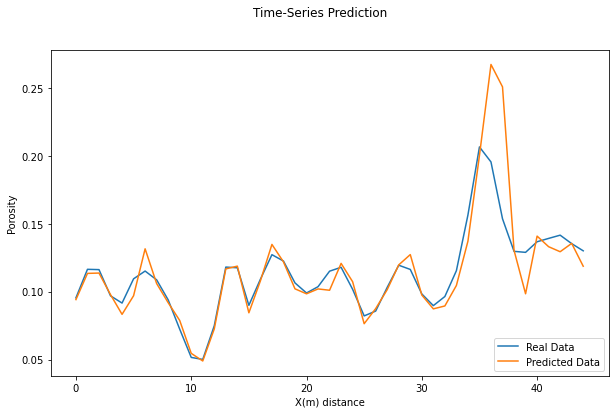

In [656]:
training_set = pd.read_csv('datasets/scaled_v3_50_100.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.06

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.25

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.8837102996272972, pvalue=9.02907656045581e-16)
STD: 0.019690964
MSE: 0.00038904377


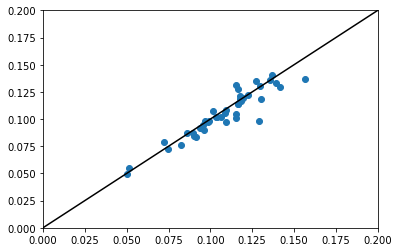

In [657]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.42683
Epoch: 100, loss: 0.02096
Epoch: 200, loss: 0.00799
Epoch: 300, loss: 0.00757
Epoch: 400, loss: 0.00705
Epoch: 500, loss: 0.00680
Epoch: 600, loss: 0.00659
Epoch: 700, loss: 0.00626
Epoch: 800, loss: 0.00573
Epoch: 900, loss: 0.00509
Epoch: 1000, loss: 0.00456
Epoch: 1100, loss: 0.00491
Epoch: 1200, loss: 0.00362
Epoch: 1300, loss: 0.00331
Epoch: 1400, loss: 0.00312
Epoch: 1500, loss: 0.00286
Epoch: 1600, loss: 0.00273
Epoch: 1700, loss: 0.00280
Epoch: 1800, loss: 0.00265
Epoch: 1900, loss: 0.00254


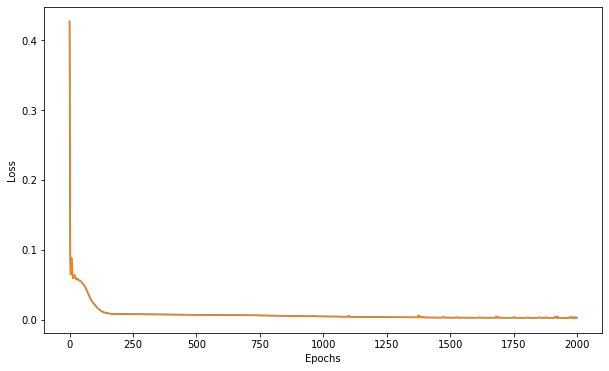

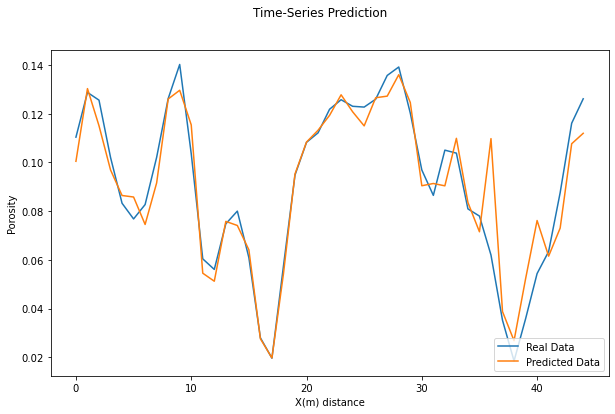

In [652]:
training_set = pd.read_csv('datasets/scaled_v3_50_515.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.06

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.25

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.948125106279535, pvalue=5.047533426889656e-23)
STD: 0.010553822
MSE: 0.00011150987


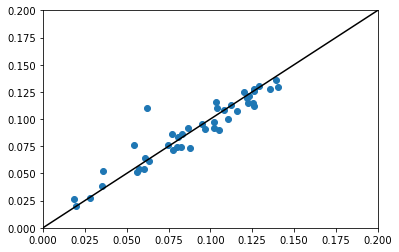

In [653]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.06259
Epoch: 100, loss: 0.00610
Epoch: 200, loss: 0.00586
Epoch: 300, loss: 0.00552
Epoch: 400, loss: 0.00515
Epoch: 500, loss: 0.00499
Epoch: 600, loss: 0.00488
Epoch: 700, loss: 0.00489
Epoch: 800, loss: 0.00467
Epoch: 900, loss: 0.00454
Epoch: 1000, loss: 0.00459
Epoch: 1100, loss: 0.00406
Epoch: 1200, loss: 0.00396
Epoch: 1300, loss: 0.00373
Epoch: 1400, loss: 0.00362
Epoch: 1500, loss: 0.00354
Epoch: 1600, loss: 0.00342
Epoch: 1700, loss: 0.00328
Epoch: 1800, loss: 0.00288
Epoch: 1900, loss: 0.00266


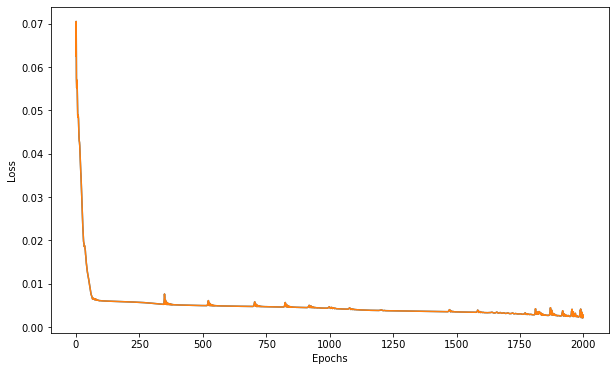

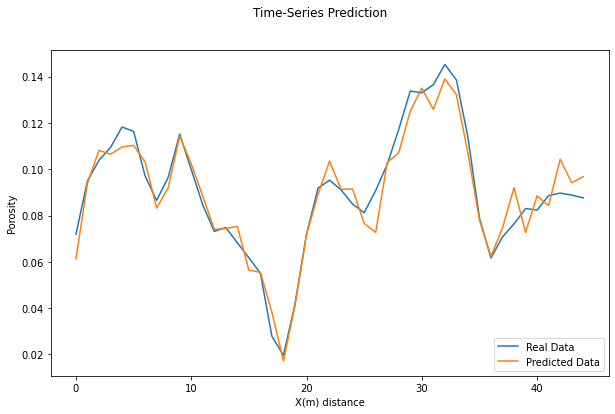

In [654]:
training_set = pd.read_csv('datasets/scaled_v3_50_999.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.06

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.25

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.966279385711205, pvalue=5.754673847884763e-27)
STD: 0.0069239372
MSE: 4.833037e-05


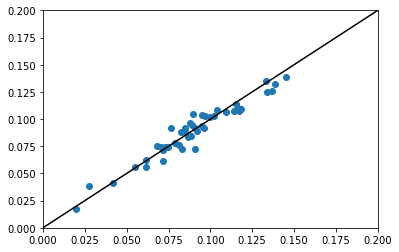

In [655]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 1.52020
Epoch: 100, loss: 0.01827
Epoch: 200, loss: 0.01480
Epoch: 300, loss: 0.00998
Epoch: 400, loss: 0.00720
Epoch: 500, loss: 0.00585
Epoch: 600, loss: 0.00488
Epoch: 700, loss: 0.00456
Epoch: 800, loss: 0.00441
Epoch: 900, loss: 0.00432
Epoch: 1000, loss: 0.00423
Epoch: 1100, loss: 0.00416
Epoch: 1200, loss: 0.00410
Epoch: 1300, loss: 0.00402
Epoch: 1400, loss: 0.00394
Epoch: 1500, loss: 0.00386
Epoch: 1600, loss: 0.00380
Epoch: 1700, loss: 0.00375
Epoch: 1800, loss: 0.00371
Epoch: 1900, loss: 0.00366


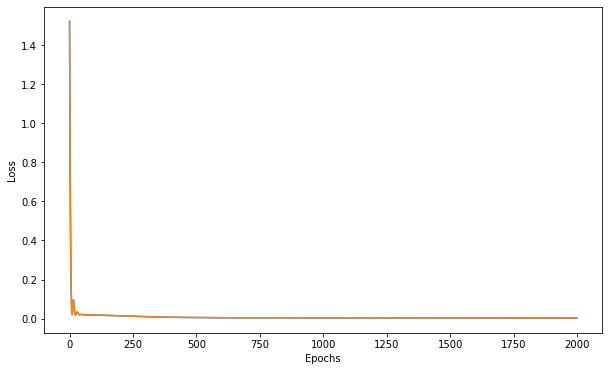

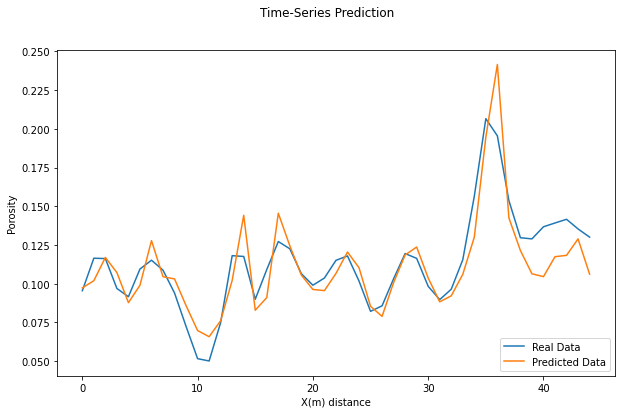

In [658]:
training_set = pd.read_csv('datasets/scaled_v4_50_100.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.06

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.25

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.8777135497477259, pvalue=2.5012708793069292e-15)
STD: 0.014680182
MSE: 0.00022092872


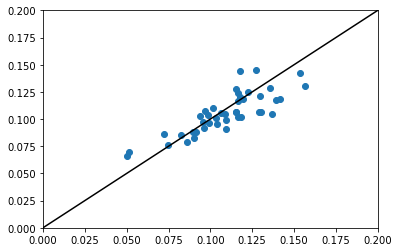

In [659]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.96800
Epoch: 100, loss: 0.03019
Epoch: 200, loss: 0.01623
Epoch: 300, loss: 0.01151
Epoch: 400, loss: 0.00907
Epoch: 500, loss: 0.00761
Epoch: 600, loss: 0.00735
Epoch: 700, loss: 0.00715
Epoch: 800, loss: 0.00693
Epoch: 900, loss: 0.00665
Epoch: 1000, loss: 0.00626
Epoch: 1100, loss: 0.00574
Epoch: 1200, loss: 0.00533
Epoch: 1300, loss: 0.00510
Epoch: 1400, loss: 0.00495
Epoch: 1500, loss: 0.00486
Epoch: 1600, loss: 0.00481
Epoch: 1700, loss: 0.00476
Epoch: 1800, loss: 0.00473
Epoch: 1900, loss: 0.00470


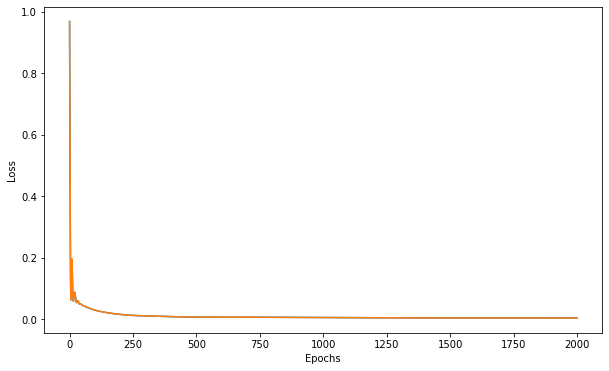

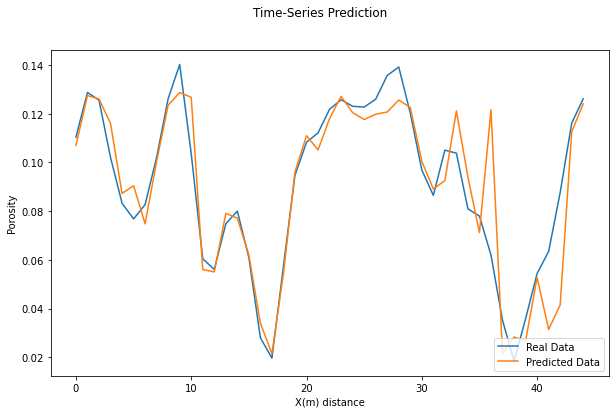

In [660]:
training_set = pd.read_csv('datasets/scaled_v4_50_515.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.06

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.25

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9072813400299227, pvalue=8.828760860564858e-18)
STD: 0.014576541
MSE: 0.00021319451


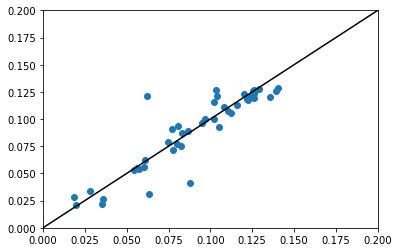

In [661]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.21222
Epoch: 100, loss: 0.01173
Epoch: 200, loss: 0.00847
Epoch: 300, loss: 0.00557
Epoch: 400, loss: 0.00489
Epoch: 500, loss: 0.00465
Epoch: 600, loss: 0.00453
Epoch: 700, loss: 0.00445
Epoch: 800, loss: 0.00443
Epoch: 900, loss: 0.00448
Epoch: 1000, loss: 0.00463
Epoch: 1100, loss: 0.00346
Epoch: 1200, loss: 0.00249
Epoch: 1300, loss: 0.00209
Epoch: 1400, loss: 0.00189
Epoch: 1500, loss: 0.00184
Epoch: 1600, loss: 0.00181
Epoch: 1700, loss: 0.00178
Epoch: 1800, loss: 0.00175
Epoch: 1900, loss: 0.00171


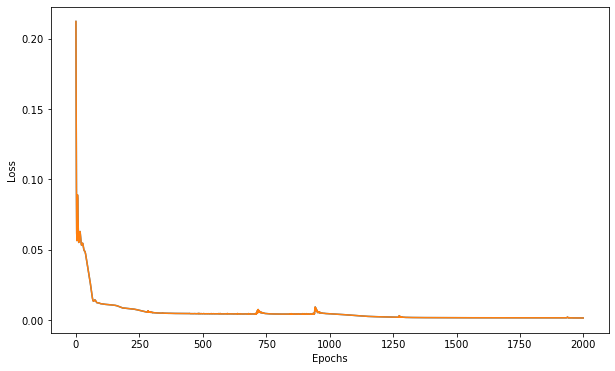

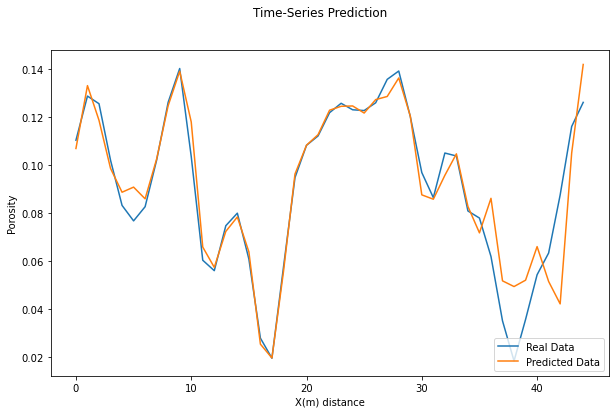

In [662]:
training_set = pd.read_csv('datasets/scaled_v4_50_515.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.06

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.25

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9412215479742441, pvalue=6.911293960276404e-22)
STD: 0.011188864
MSE: 0.00012624808


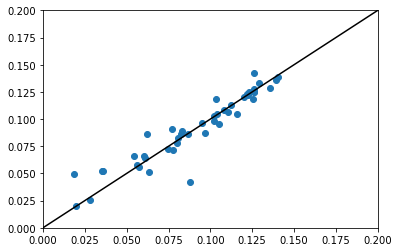

In [663]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.78571
Epoch: 100, loss: 0.01684
Epoch: 200, loss: 0.00803
Epoch: 300, loss: 0.00720
Epoch: 400, loss: 0.00678
Epoch: 500, loss: 0.00626
Epoch: 600, loss: 0.00606
Epoch: 700, loss: 0.00602
Epoch: 800, loss: 0.00601
Epoch: 900, loss: 0.00599
Epoch: 1000, loss: 0.00598
Epoch: 1100, loss: 0.00594
Epoch: 1200, loss: 0.00589
Epoch: 1300, loss: 0.00582
Epoch: 1400, loss: 0.00575
Epoch: 1500, loss: 0.00567
Epoch: 1600, loss: 0.00562
Epoch: 1700, loss: 0.00557
Epoch: 1800, loss: 0.00548
Epoch: 1900, loss: 0.00538


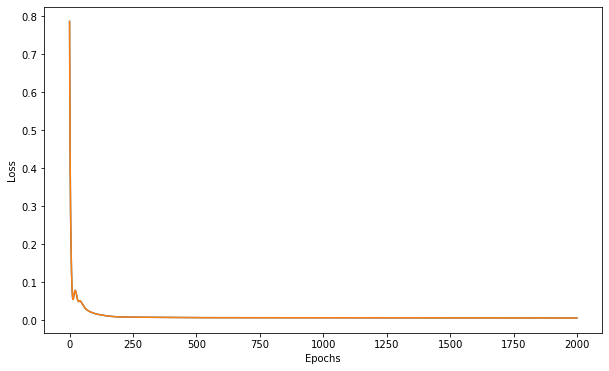

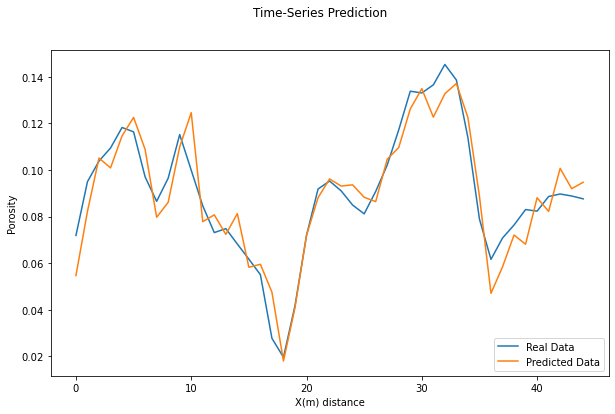

In [664]:
training_set = pd.read_csv('datasets/scaled_v4_50_999.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.06

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.25

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9394267693429079, pvalue=1.295853808980143e-21)
STD: 0.009283827
MSE: 8.652304e-05


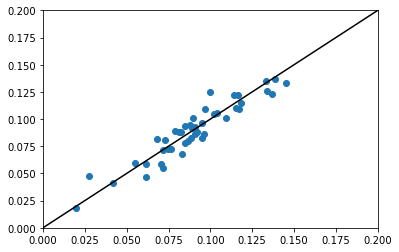

In [665]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

## Scaled 20

In [81]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, p):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.p = p
        #self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_layers)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        
        return out

Epoch: 0, loss: 0.60321
Epoch: 100, loss: 0.04670
Epoch: 200, loss: 0.03099
Epoch: 300, loss: 0.02663
Epoch: 400, loss: 0.02215
Epoch: 500, loss: 0.01143
Epoch: 600, loss: 0.00685
Epoch: 700, loss: 0.00315
Epoch: 800, loss: 0.00057
Epoch: 900, loss: 0.00023
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000
Epoch: 1400, loss: 0.00000
Epoch: 1500, loss: 0.00000
Epoch: 1600, loss: 0.00000
Epoch: 1700, loss: 0.00000
Epoch: 1800, loss: 0.00008
Epoch: 1900, loss: 0.00000


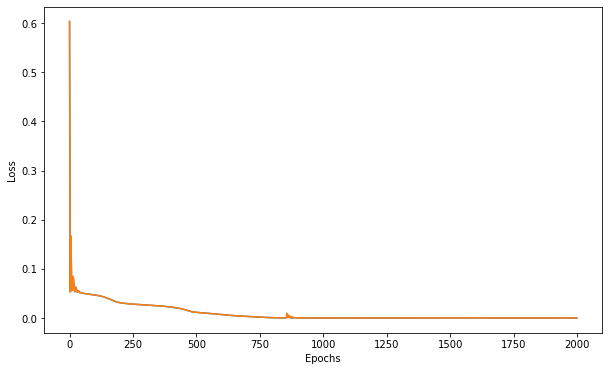

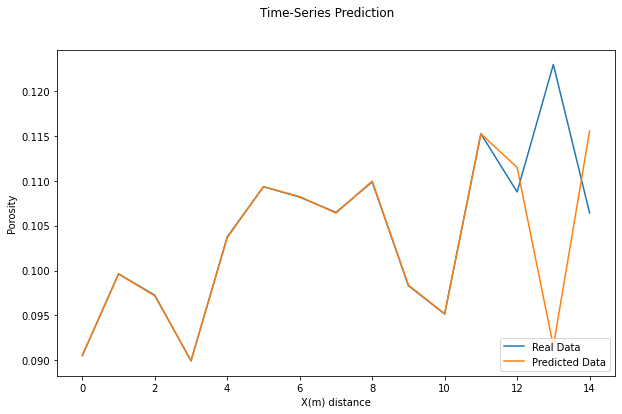

In [26]:
training_set = pd.read_csv('datasets/scaled_v1_20_300.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.07

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2


lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.5321107714297445, pvalue=0.04117309166213275)
STD: 0.008370279
MSE: 7.174925e-05


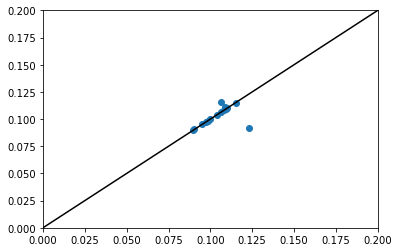

In [27]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.78962
Epoch: 100, loss: 0.03441
Epoch: 200, loss: 0.03331
Epoch: 300, loss: 0.03256
Epoch: 400, loss: 0.03138
Epoch: 500, loss: 0.02987
Epoch: 600, loss: 0.02857
Epoch: 700, loss: 0.02696
Epoch: 800, loss: 0.02413
Epoch: 900, loss: 0.01454
Epoch: 1000, loss: 0.01211
Epoch: 1100, loss: 0.00922
Epoch: 1200, loss: 0.00709
Epoch: 1300, loss: 0.00442
Epoch: 1400, loss: 0.00184
Epoch: 1500, loss: 0.00155
Epoch: 1600, loss: 0.00138
Epoch: 1700, loss: 0.00140
Epoch: 1800, loss: 0.00117
Epoch: 1900, loss: 0.00111


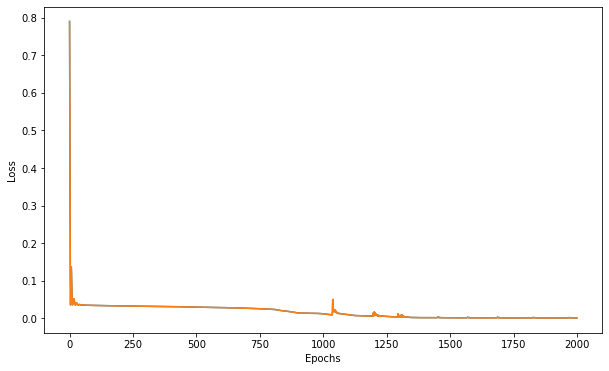

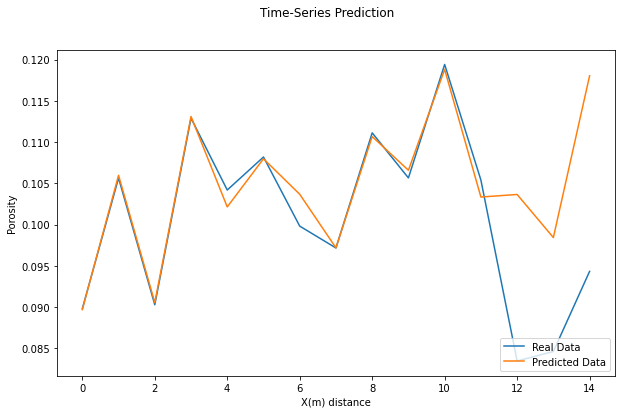

In [40]:
training_set = pd.read_csv('datasets/scaled_v1_20_490.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.07

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2


lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.6465391977854652, pvalue=0.009198638000549408)
STD: 0.008013303
MSE: 7.908054e-05


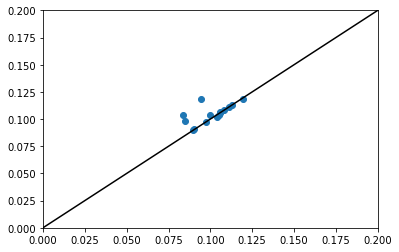

In [41]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.27644
Epoch: 100, loss: 0.08928
Epoch: 200, loss: 0.08625
Epoch: 300, loss: 0.08014
Epoch: 400, loss: 0.05700
Epoch: 500, loss: 0.02008
Epoch: 600, loss: 0.00071
Epoch: 700, loss: 0.00002
Epoch: 800, loss: 0.00001
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00001
Epoch: 1100, loss: 0.00055
Epoch: 1200, loss: 0.00002
Epoch: 1300, loss: 0.00012
Epoch: 1400, loss: 0.00016
Epoch: 1500, loss: 0.00006
Epoch: 1600, loss: 0.00003
Epoch: 1700, loss: 0.00001
Epoch: 1800, loss: 0.00050
Epoch: 1900, loss: 0.00001


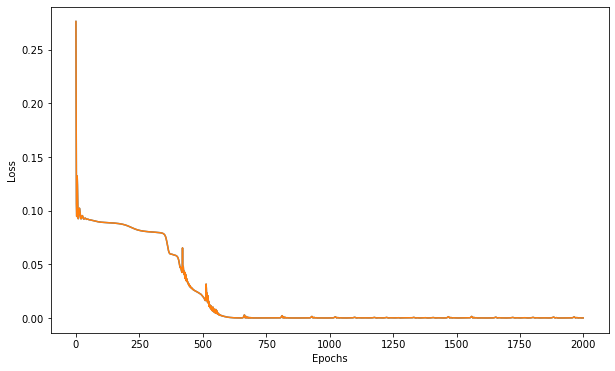

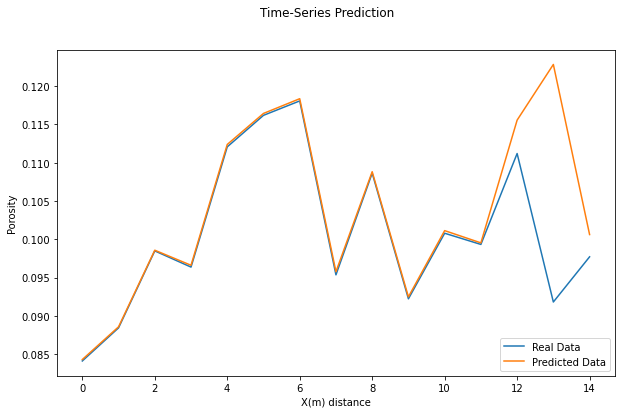

In [30]:
training_set = pd.read_csv('datasets/scaled_v1_20_980.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.07

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.7452368515004938, pvalue=0.0014299519494423373)
STD: 0.0076500494
MSE: 6.6066605e-05


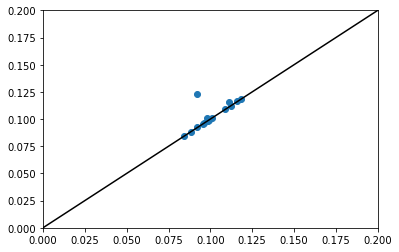

In [31]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.43063
Epoch: 100, loss: 0.03073
Epoch: 200, loss: 0.03069
Epoch: 300, loss: 0.03057
Epoch: 400, loss: 0.02992
Epoch: 500, loss: 0.02306
Epoch: 600, loss: 0.01968
Epoch: 700, loss: 0.01577
Epoch: 800, loss: 0.01323
Epoch: 900, loss: 0.01226
Epoch: 1000, loss: 0.01030
Epoch: 1100, loss: 0.00720
Epoch: 1200, loss: 0.00387
Epoch: 1300, loss: 0.00229


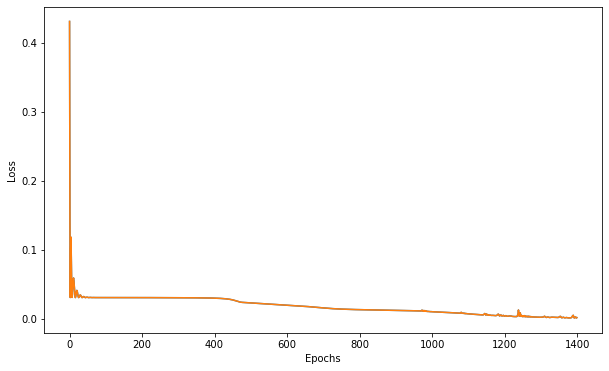

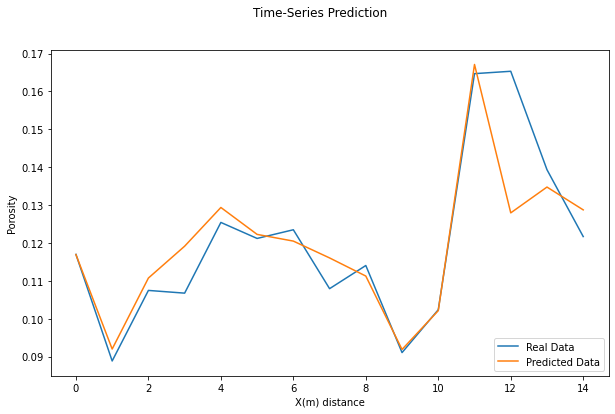

In [47]:
training_set = pd.read_csv('datasets/scaled_v2_20_300.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 1400
learning_rate = 0.1

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.8702846369567624, pvalue=2.454300513312985e-05)
STD: 0.010787452
MSE: 0.00011651873


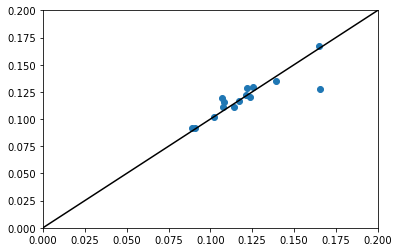

In [48]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.10339
Epoch: 100, loss: 0.02162
Epoch: 200, loss: 0.00698
Epoch: 300, loss: 0.00519
Epoch: 400, loss: 0.00488
Epoch: 500, loss: 0.00470
Epoch: 600, loss: 0.00456
Epoch: 700, loss: 0.00444
Epoch: 800, loss: 0.00434
Epoch: 900, loss: 0.00425
Epoch: 1000, loss: 0.00418
Epoch: 1100, loss: 0.00421
Epoch: 1200, loss: 0.00406
Epoch: 1300, loss: 0.00402


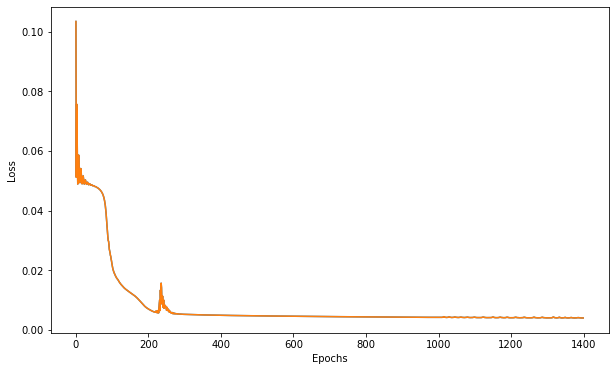

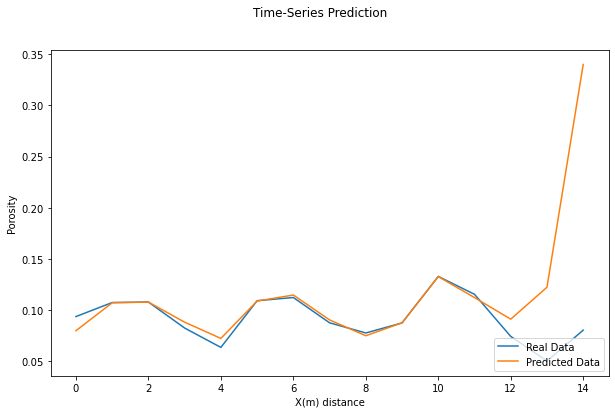

In [49]:
training_set = pd.read_csv('datasets/scaled_v2_20_490.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 1400
learning_rate = 0.1

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.0019462092152501553, pvalue=0.9945076954815079)
STD: 0.065898456
MSE: 0.0048805648


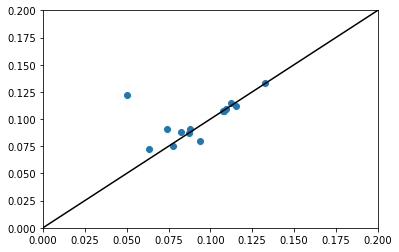

In [50]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.15542
Epoch: 100, loss: 0.04995
Epoch: 200, loss: 0.03888
Epoch: 300, loss: 0.03619
Epoch: 400, loss: 0.02881
Epoch: 500, loss: 0.02266
Epoch: 600, loss: 0.01751
Epoch: 700, loss: 0.01033
Epoch: 800, loss: 0.01037
Epoch: 900, loss: 0.00668
Epoch: 1000, loss: 0.00428
Epoch: 1100, loss: 0.00259
Epoch: 1200, loss: 0.00179
Epoch: 1300, loss: 0.00129


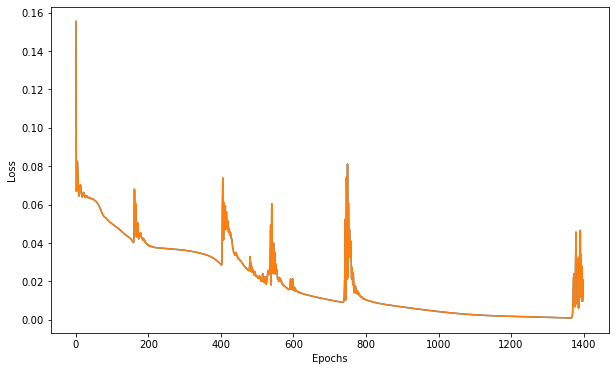

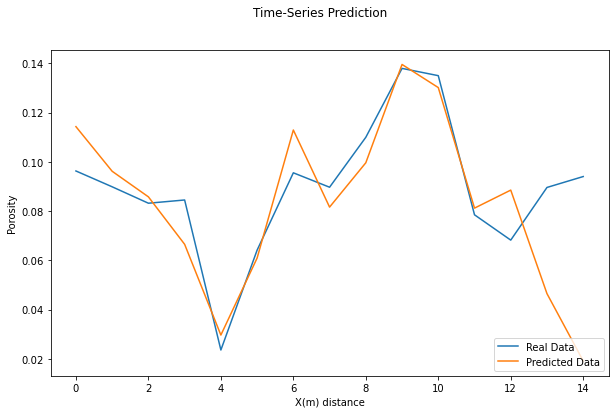

In [52]:
training_set = pd.read_csv('datasets/scaled_v2_20_980.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 1400
learning_rate = 0.1

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2


lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.7035434505136333, pvalue=0.0034261800707697456)
STD: 0.02396036
MSE: 0.00060811924


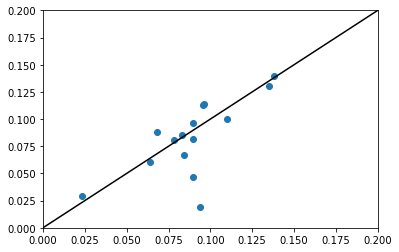

In [53]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.23902
Epoch: 100, loss: 0.02214
Epoch: 200, loss: 0.02204
Epoch: 300, loss: 0.02197
Epoch: 400, loss: 0.02173
Epoch: 500, loss: 0.02107
Epoch: 600, loss: 0.02080
Epoch: 700, loss: 0.02026
Epoch: 800, loss: 0.01896
Epoch: 900, loss: 0.01689
Epoch: 1000, loss: 0.01569
Epoch: 1100, loss: 0.01232
Epoch: 1200, loss: 0.00609
Epoch: 1300, loss: 0.00341


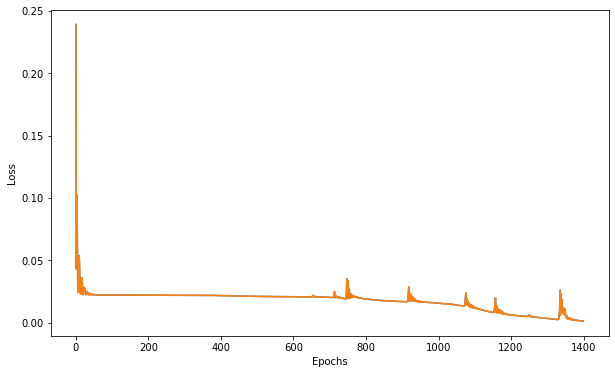

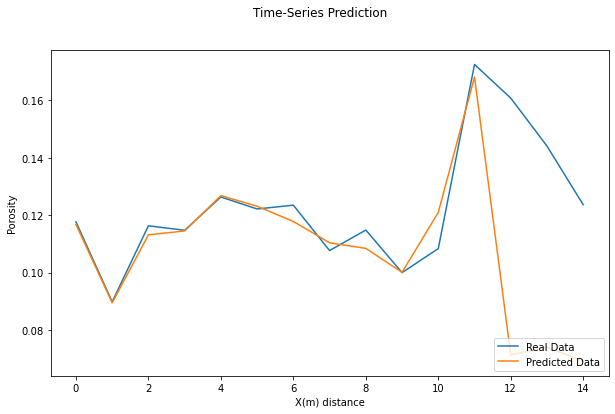

In [55]:
training_set = pd.read_csv('datasets/scaled_v3_20_300.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 1400
learning_rate = 0.1

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.17302058484151703, pvalue=0.537465088482015)
STD: 0.029431192
MSE: 0.0010781243


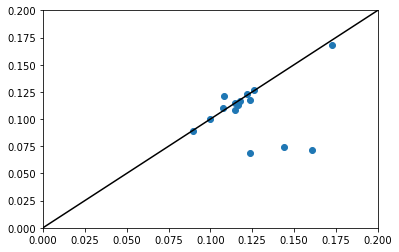

In [56]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.85302
Epoch: 100, loss: 0.03410
Epoch: 200, loss: 0.03376
Epoch: 300, loss: 0.03346
Epoch: 400, loss: 0.03339
Epoch: 500, loss: 0.03332
Epoch: 600, loss: 0.03318
Epoch: 700, loss: 0.03281
Epoch: 800, loss: 0.03105
Epoch: 900, loss: 0.02886
Epoch: 1000, loss: 0.01581
Epoch: 1100, loss: 0.00752
Epoch: 1200, loss: 0.00285
Epoch: 1300, loss: 0.00295


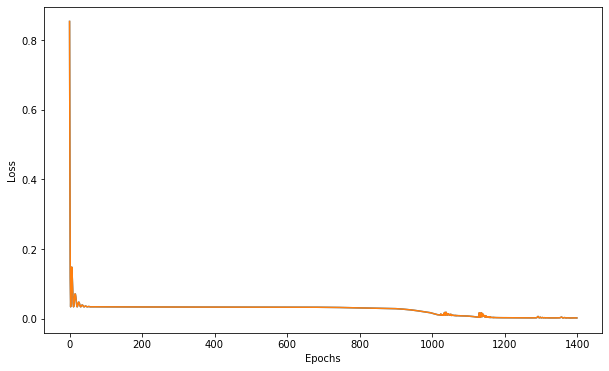

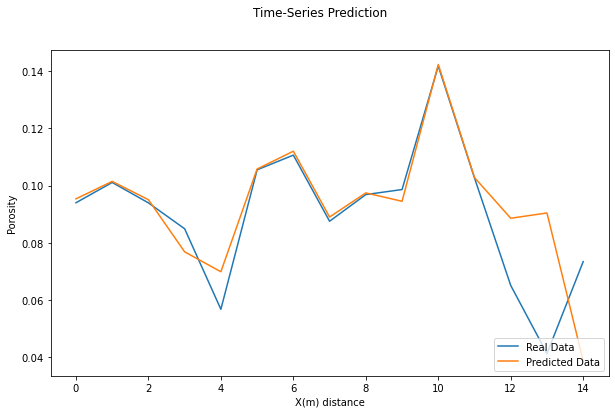

In [57]:
training_set = pd.read_csv('datasets/scaled_v3_20_490.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 1400
learning_rate = 0.1

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.7186646202457609, pvalue=0.002539010203597416)
STD: 0.016915282
MSE: 0.0002955625


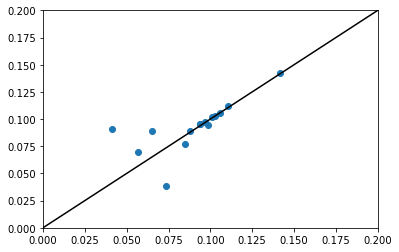

In [58]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.99363
Epoch: 100, loss: 0.06466
Epoch: 200, loss: 0.06098
Epoch: 300, loss: 0.05679
Epoch: 400, loss: 0.05264
Epoch: 500, loss: 0.04929
Epoch: 600, loss: 0.04696
Epoch: 700, loss: 0.04538
Epoch: 800, loss: 0.04423
Epoch: 900, loss: 0.04331
Epoch: 1000, loss: 0.04246
Epoch: 1100, loss: 0.04149
Epoch: 1200, loss: 0.04011
Epoch: 1300, loss: 0.03537


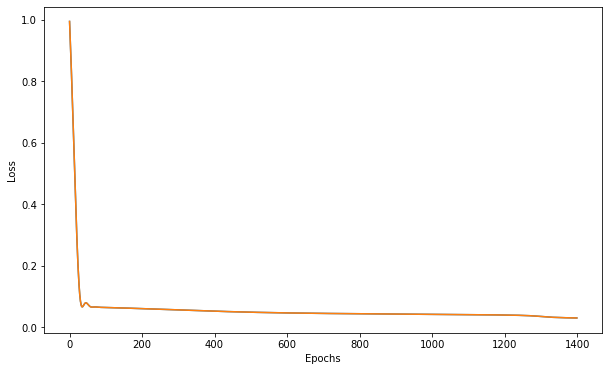

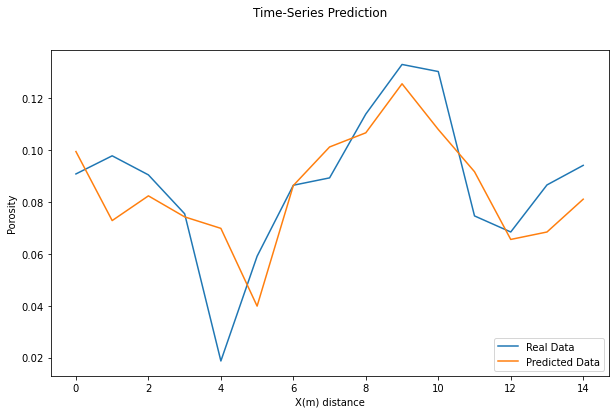

In [82]:
training_set = pd.read_csv('datasets/scaled_v3_20_980.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 1400
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.7260791654748315, pvalue=0.0021770994931162658)
STD: 0.01863333
MSE: 0.00035293456


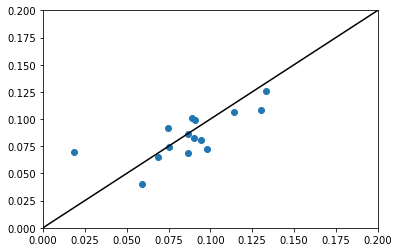

In [83]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.06632
Epoch: 100, loss: 0.02196
Epoch: 200, loss: 0.02190
Epoch: 300, loss: 0.02173
Epoch: 400, loss: 0.02083
Epoch: 500, loss: 0.01682
Epoch: 600, loss: 0.00943
Epoch: 700, loss: 0.00642
Epoch: 800, loss: 0.00511
Epoch: 900, loss: 0.00369


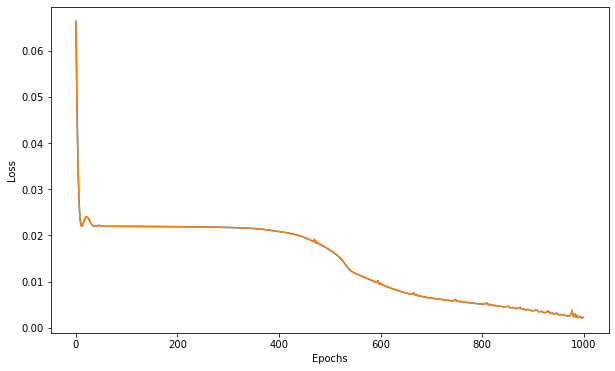

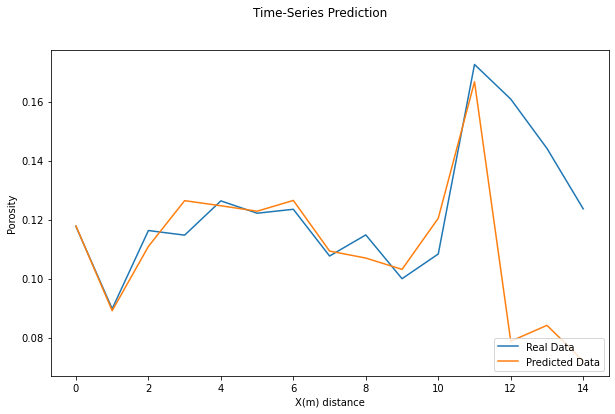

In [86]:
training_set = pd.read_csv('datasets/scaled_v4_20_300.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 1000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.22929143402042956, pvalue=0.41105498625883186)
STD: 0.027305018
MSE: 0.0008933985


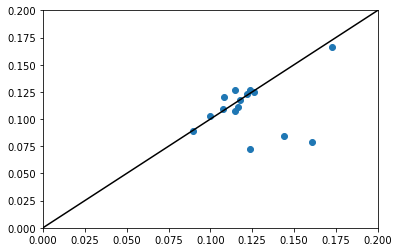

In [87]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.07156
Epoch: 100, loss: 0.03455
Epoch: 200, loss: 0.03438
Epoch: 300, loss: 0.03344
Epoch: 400, loss: 0.01421
Epoch: 500, loss: 0.00958
Epoch: 600, loss: 0.00810
Epoch: 700, loss: 0.00686
Epoch: 800, loss: 0.00632
Epoch: 900, loss: 0.00597
Epoch: 1000, loss: 0.00554
Epoch: 1100, loss: 0.00451
Epoch: 1200, loss: 0.00326
Epoch: 1300, loss: 0.00170


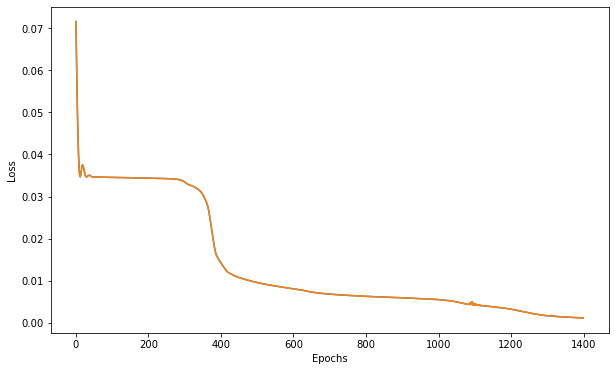

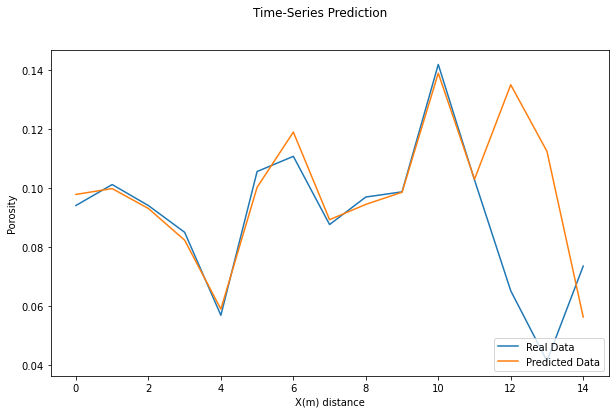

In [88]:
training_set = pd.read_csv('datasets/scaled_v4_20_490.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 1400
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.3990438427388199, pvalue=0.14063198986384084)
STD: 0.024952285
MSE: 0.00069050153


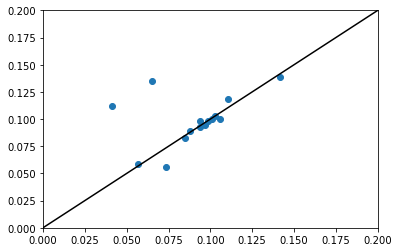

In [89]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.38262
Epoch: 100, loss: 0.05882
Epoch: 200, loss: 0.04911
Epoch: 300, loss: 0.04500
Epoch: 400, loss: 0.03540
Epoch: 500, loss: 0.03119
Epoch: 600, loss: 0.02783
Epoch: 700, loss: 0.02506
Epoch: 800, loss: 0.02271
Epoch: 900, loss: 0.02078


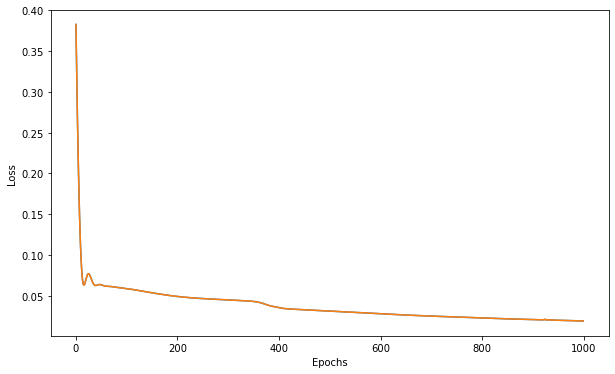

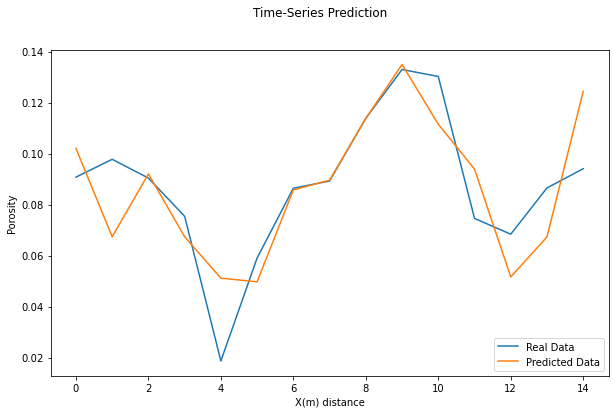

In [92]:
training_set = pd.read_csv('datasets/scaled_v4_20_980.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 1000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.7873104187446371, pvalue=0.0004940036008157994)
STD: 0.01742931
MSE: 0.00030392612


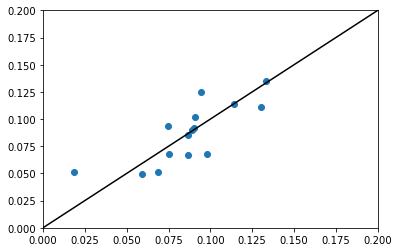

In [93]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

## Scale 10

In [2]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [3]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, p):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.p = p
        #self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_layers)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        
        return out

Epoch: 0, loss: 1.97239
Epoch: 100, loss: 0.02240
Epoch: 200, loss: 0.01889
Epoch: 300, loss: 0.01607


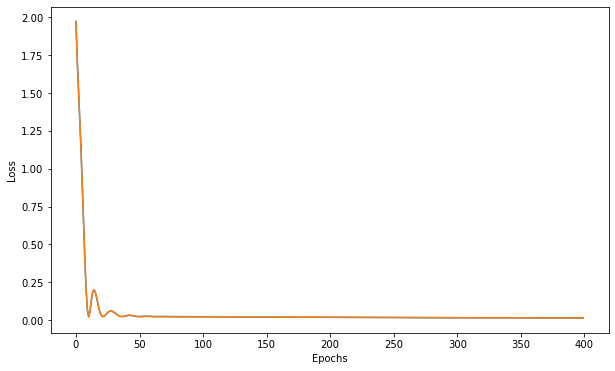

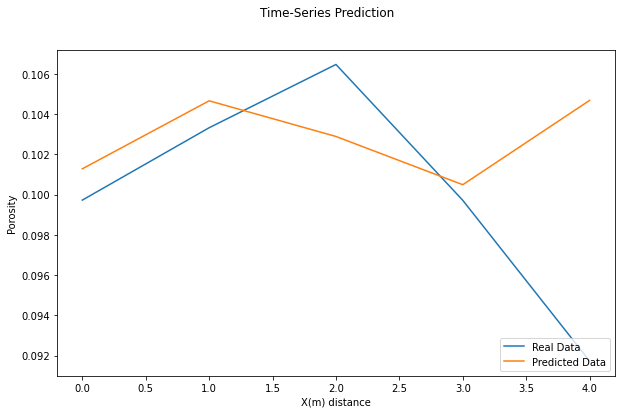

In [4]:
training_set = pd.read_csv('datasets/scaled_v1_10_495.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 400
learning_rate = 0.05

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=-0.18336269250174553, pvalue=0.7678503004986855)
STD: 0.0055035525
MSE: 3.709769e-05


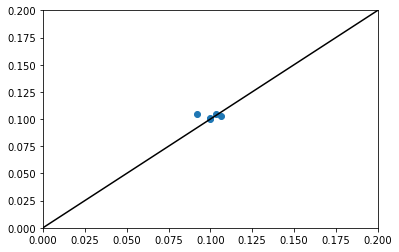

In [5]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 1.35393
Epoch: 100, loss: 0.03429
Epoch: 200, loss: 0.01121
Epoch: 300, loss: 0.00000


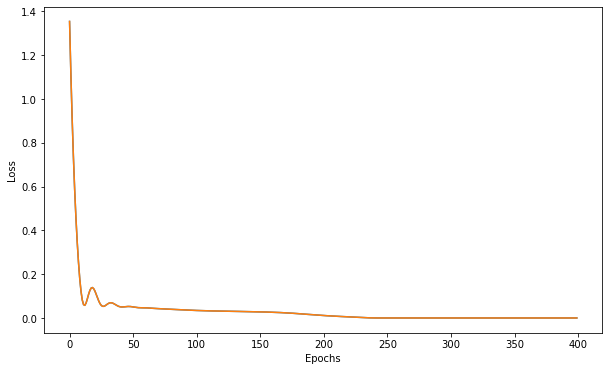

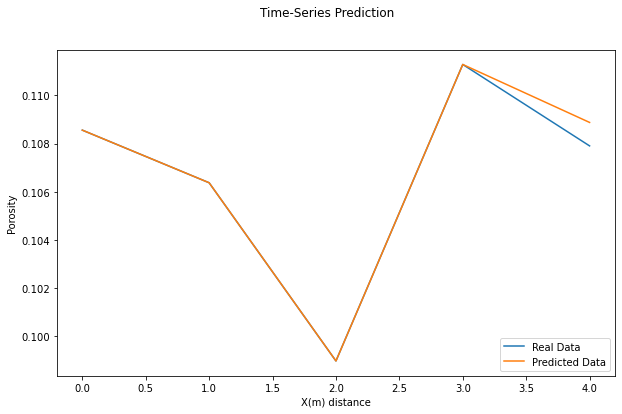

In [97]:
training_set = pd.read_csv('datasets/scaled_v1_10_700.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 400
learning_rate = 0.05

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9958273483001209, pvalue=0.00032335534865973996)
STD: 0.0003896326
MSE: 1.8976115e-07


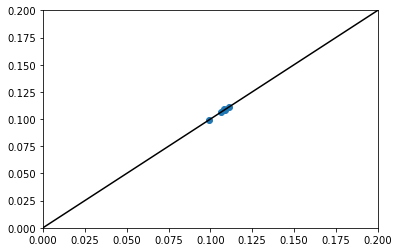

In [98]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.85243
Epoch: 100, loss: 0.05745
Epoch: 200, loss: 0.05729
Epoch: 300, loss: 0.04379


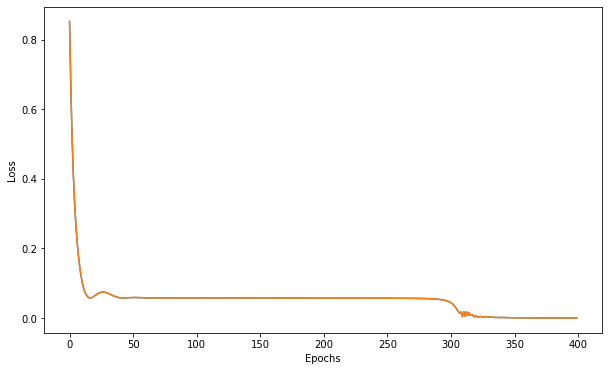

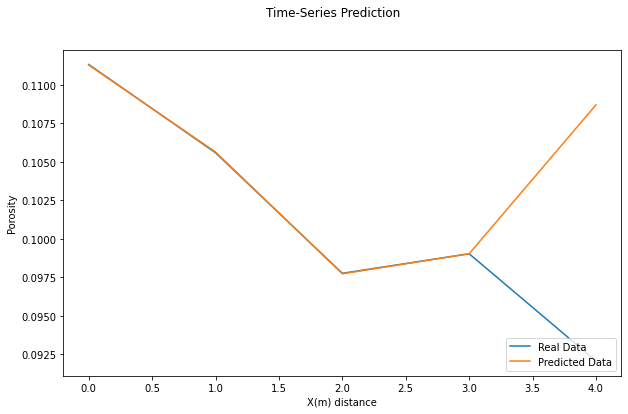

In [100]:
training_set = pd.read_csv('datasets/scaled_v1_10_970.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 400
learning_rate = 0.05

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.39913428332361434, pvalue=0.5056420258151548)
STD: 0.0066626724
MSE: 5.545555e-05


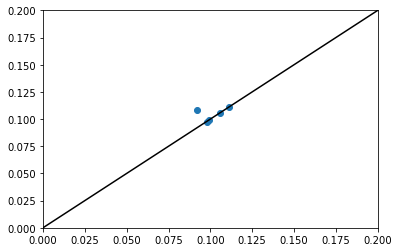

In [101]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.03824
Epoch: 100, loss: 0.00409
Epoch: 200, loss: 0.00031
Epoch: 300, loss: 0.00000


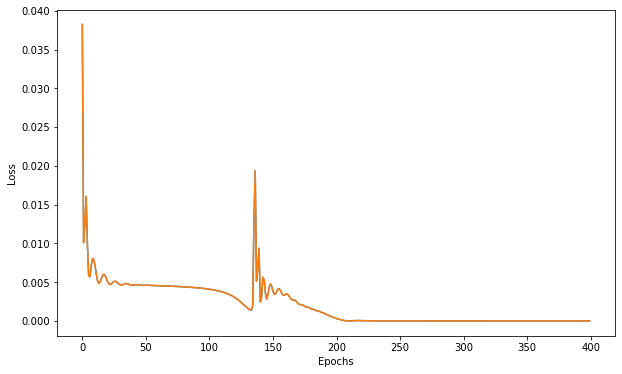

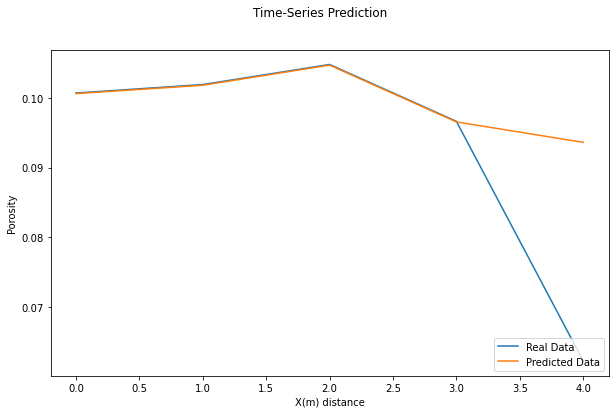

In [102]:
training_set = pd.read_csv('datasets/scaled_v2_10_495.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 400
learning_rate = 0.05

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.8454983591301122, pvalue=0.0711874685660397)
STD: 0.0125726545
MSE: 0.00019645765


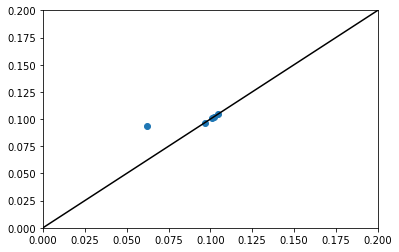

In [103]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 1.48057
Epoch: 100, loss: 0.07864
Epoch: 200, loss: 0.00021
Epoch: 300, loss: 0.00000


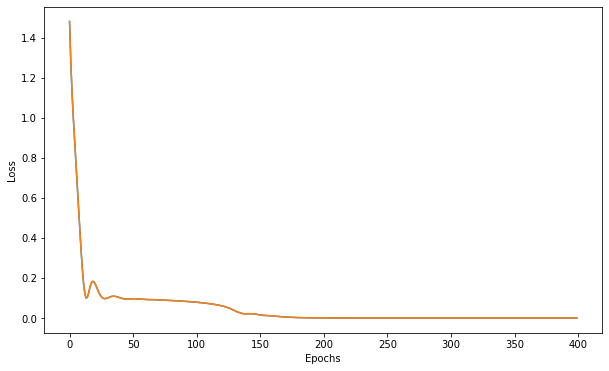

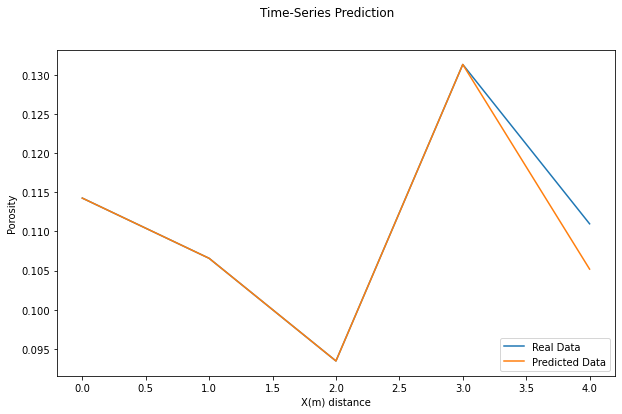

In [113]:
training_set = pd.read_csv('datasets/scaled_v2_10_700.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 400
learning_rate = 0.05

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9827175600292503, pvalue=0.002720272325395466)
STD: 0.0023135052
MSE: 6.690374e-06


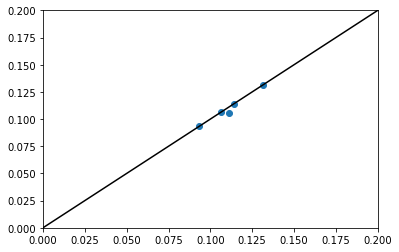

In [114]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.90245
Epoch: 100, loss: 0.02949
Epoch: 200, loss: 0.00000
Epoch: 300, loss: 0.00000


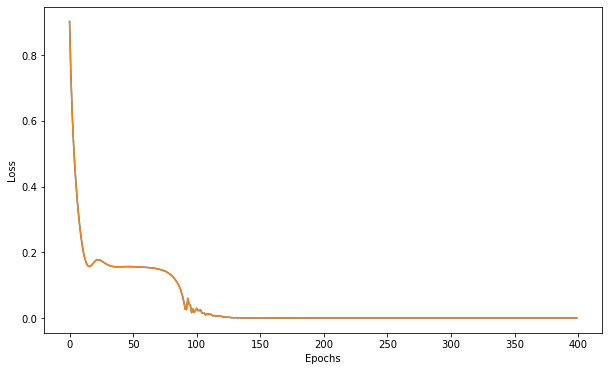

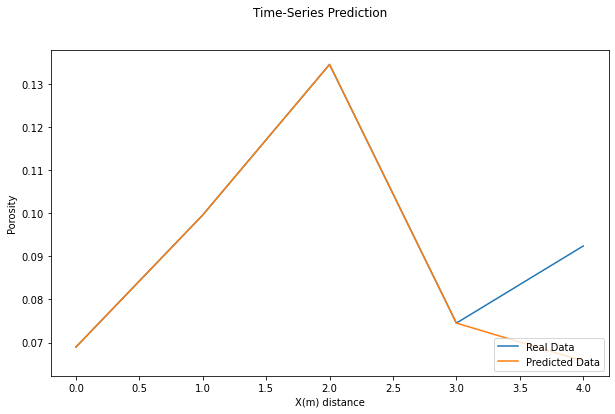

In [115]:
training_set = pd.read_csv('datasets/scaled_v2_10_970.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 400
learning_rate = 0.05

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9108392758808821, pvalue=0.03152819053773013)
STD: 0.010668913
MSE: 0.0001422822


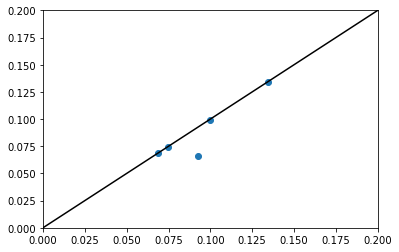

In [116]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.01533
Epoch: 100, loss: 0.00055
Epoch: 200, loss: 0.00011
Epoch: 300, loss: 0.00002


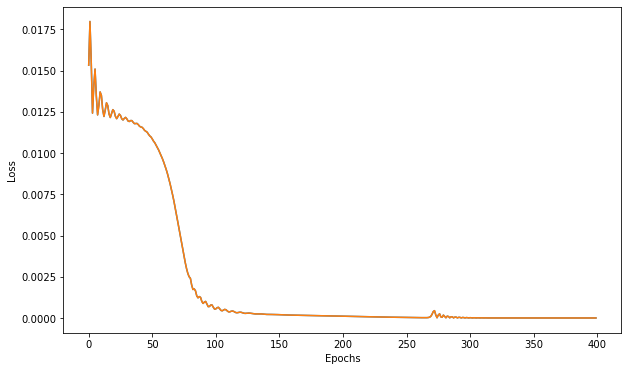

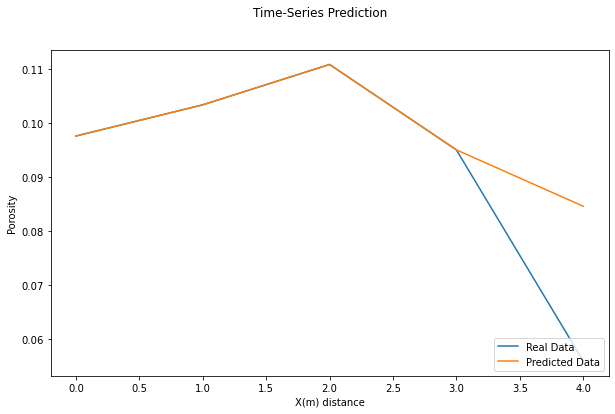

In [117]:
training_set = pd.read_csv('datasets/scaled_v3_10_495.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 400
learning_rate = 0.05

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9277761835106157, pvalue=0.023045851744634784)
STD: 0.01147238
MSE: 0.00016451477


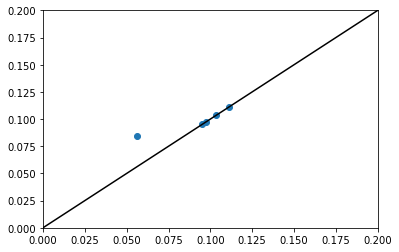

In [118]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.12189
Epoch: 100, loss: 0.00329
Epoch: 200, loss: 0.00000
Epoch: 300, loss: 0.00000


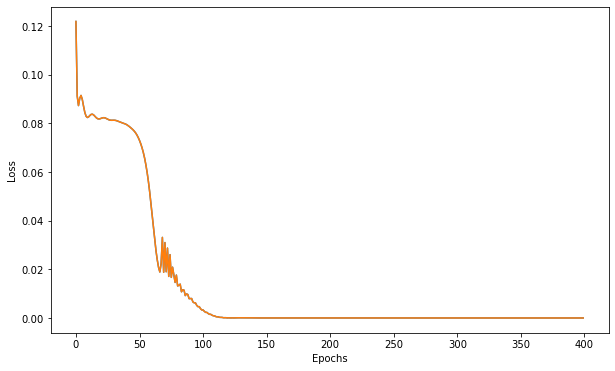

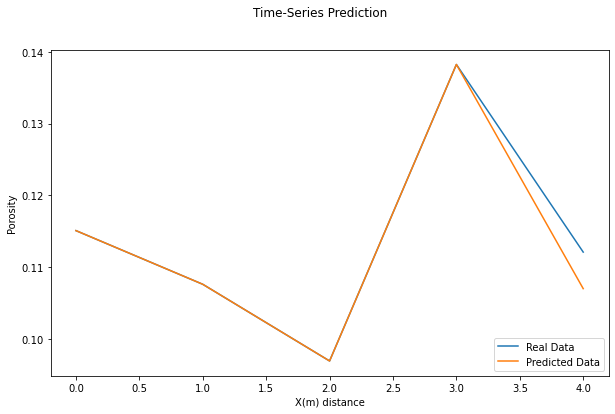

In [119]:
training_set = pd.read_csv('datasets/scaled_v4_10_700.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 400
learning_rate = 0.05

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9892434942463141, pvalue=0.001337022491785036)
STD: 0.002037237
MSE: 5.1879288e-06


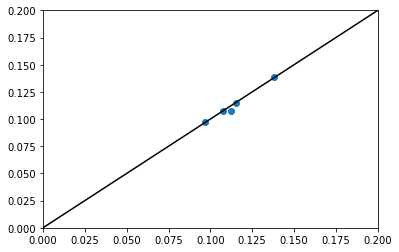

In [120]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.14782
Epoch: 100, loss: 0.00000
Epoch: 200, loss: 0.00000
Epoch: 300, loss: 0.00057


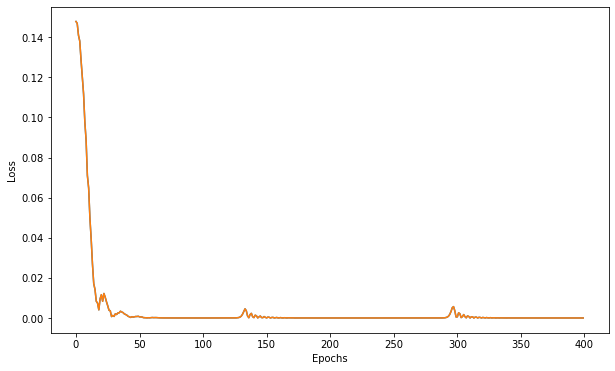

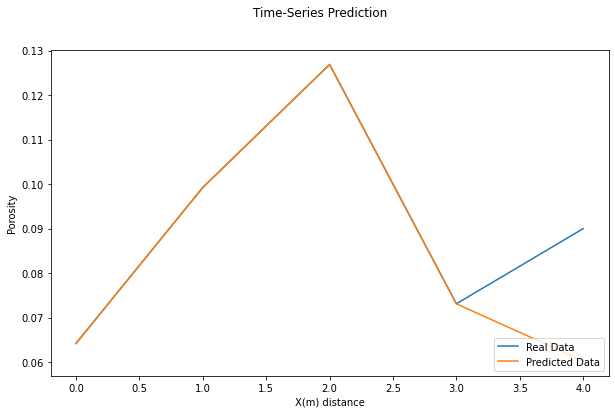

In [121]:
training_set = pd.read_csv('datasets/scaled_v4_10_970.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 400
learning_rate = 0.05

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.8803961917786289, pvalue=0.04875311537685417)
STD: 0.0118915
MSE: 0.00017694086


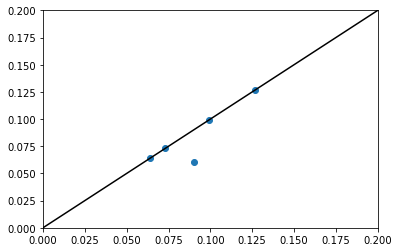

In [122]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
#from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))